In [1]:
import sys
import os

app_base_dir = '/home/eusobg/EUSO-SPB/euso-spb-patt-reco-v1'
if app_base_dir not in sys.path:
    sys.path.append(app_base_dir)

import re
# import collections
import numpy as np
import psycopg2 as pg
import scipy.ndimage.filters
import scipy.signal
# import pandas as pd
# import pandas.io.sql as psql
# import matplotlib as mpl
import matplotlib as mpl
import matplotlib.pyplot as plt
# from tqdm import tqdm
# import glob
#import ROOT
import skimage
import skimage.filters
import skimage.restoration
import skimage.morphology

In [2]:
import supervised_classification as supc
import tool.acqconv

Welcome to JupyROOT 6.10/00


In [3]:
con = pg.connect("dbname=eusospb_data user=eusospb password=1e20eVjemeuso host=localhost")
cur = con.cursor()

In [4]:
columns = ['event_id', 'packet_id', 'gtu_in_packet', 'num_gtu','source_file_acquisition_full']
#visible_showers = supervised_classification.select_training_data__visible_showers(cur, columns);
visible_showers = supc.select_events(cur, supc.get_select_simu_events_query_format(5, 999, 3, 800, 3), columns, limit=100000)[0]
invisible_showers = supc.select_training_data__invisible_showers(cur, columns)
low_energy_in_pmt = supc.select_training_data__low_energy_in_pmt(cur, columns) # maybe too many gtu
led = supc.select_training_data__led(cur, columns)

Executing query: 
SELECT 
          event_id,packet_id,gtu_in_packet,num_gtu,source_file_acquisition_full
        FROM spb_processing_event_ver2
        JOIN simu_event_spb_proc USING (event_id) 
        JOIN simu_event USING (simu_event_id) 
        JOIN simu_event_spb_proc_additional_info USING (relation_id) 
        WHERE 
        
         source_data_type_num = 3
         AND etruth_truetheta > 0.2618
         AND num_triggered_pixels BETWEEN 3 AND 800
         AND num_frames_signals_ge_bg BETWEEN 5 AND 999 
         
        ORDER BY num_triggered_pixels ASC, event_id ASC 
        OFFSET 0 LIMIT 100000
        ;
# Selected 4011 entries
Executing query: 
SELECT 
          event_id,packet_id,gtu_in_packet,num_gtu,source_file_acquisition_full
        FROM spb_processing_event_ver2
        JOIN simu_event_spb_proc USING (event_id) 
        JOIN simu_event USING (simu_event_id) 
        JOIN simu_event_spb_proc_additional_info USING (relation_id) 
        WHERE 
        
         sour

In [5]:
visible_showers

[(1011953,
  1,
  34,
  12,
  '/home/eusobg/EUSO-SPB/SPBDATA_processed/spb_simu/posz_21000000.00/energy_1.00e+13/thousnd21E20.2017-07-28-17h10m10s/npyconv/ev_9_mc_1__signals_p128_a0_g30_f128_b20170501-133354-001.001_k1_s0_d32_n4_m128.npy'),
 (1013574,
  1,
  36,
  12,
  '/home/eusobg/EUSO-SPB/SPBDATA_processed/spb_simu/posz_18000000.00/energy_1.70e+12/Ssegv18.2017-07-07-19h46m33s/npyconv/ev_96_mc_1__signals_p128_a0_g30_f128_b20170502-124722-001.001_k1_s0_d32_n16_m128.npy'),
 (1014843,
  1,
  44,
  10,
  '/home/eusobg/EUSO-SPB/SPBDATA_processed/spb_simu/posz_21000000.00/energy_1.41e+12/thousnd21E3.2017-07-26-20h06m01s/npyconv/ev_11_mc_1__signals_p128_a0_g30_f128_b20170501-133354-001.001_k1_s0_d32_n1_m128.npy'),
 (1015091,
  1,
  39,
  11,
  '/home/eusobg/EUSO-SPB/SPBDATA_processed/spb_simu/posz_21000000.00/energy_1.58e+12/thousnd21E4.2017-07-26-20h44m47s/npyconv/ev_80_mc_1__signals_p128_a0_g30_f128_b20170501-133354-001.001_k1_s0_d32_n17_m128.npy'),
 (1015291,
  1,
  38,
  9,
  '/home/eu

In [6]:
# save_npy_dir_pathname = '/mnt/miso_data2_4tb/nn_training_data/'
save_npy_dir_pathname = '/media/node15_data2/nn_training_data'

In [7]:
# re_acq_pathname = re.compile(r"^(.+)\/npyconv\/(ev_(\d+)_mc_1__signals).+$")

# num_visualized_entries = 20
# subplot_cols = 8
# subplot_rows = int(np.ceil((num_visualized_entries * 2 + 1) / subplot_cols))

def read_projections(all_rows, packet_simu_sequence_length = 35, packet_simu_data_gtu_offset = 30, max_entries=None, substract_bg=False, bgframes_length=30, bgframes_offset=0, apply_gaussian_filter=True, gaussian_filter_sigma=3):

    xy_projections = np.zeros((len(all_rows), 48, 48),dtype=np.float32)
    gtux_projections = np.zeros((len(all_rows), 48, packet_simu_sequence_length),dtype=np.float32)
    gtuy_projections = np.zeros((len(all_rows), 48, packet_simu_sequence_length),dtype=np.float32)

    for i, r in enumerate(all_rows):
        
        if max_entries is not None and max_entries >= 0 and i >= max_entries:
            break
            
        event_id, packet_id, gtu_in_packet, num_gtu, acquisition_file = r
        gtu_in_packet_corrected = max(gtu_in_packet - 4, 0)
        
        if gtu_in_packet_corrected + num_gtu < 30:
            print('#{}  ID {}  gtu_in_packet + num_gtu - 4 < 30'.format(i, event_id))
            continue
        
        if acquisition_file.endswith('.npy'):
            acquisition_arr = np.load(acquisition_file)[packet_id * 128:packet_id*128+128]
#             frames_acquisition = acquisition_arr[gtu_in_packet_corrected:packet_id * 128 + gtu_in_packet_corrected + num_gtu]                
        elif acquisition_file.endswith('.root'):
            acquisition_arr = tool.acqconv.get_frames(acquisition_file,
                                                         packet_id * 128 ,
                                                         packet_id * 128 + 127, 
                                                         entry_is_gtu_optimization=True)
        
        frames_acquisition = acquisition_arr[gtu_in_packet_corrected:gtu_in_packet_corrected + num_gtu]
        
        if substract_bg:
            avg_frames_background = np.add.reduce(acquisition_arr[bgframes_offset:bgframes_offset+bgframes_length])/min(bgframes_length,len(acquisition_arr[bgframes_offset:]))
            if apply_gaussian_filter:
                avg_frames_background = scipy.ndimage.filters.gaussian_filter(avg_frames_background, gaussian_filter_sigma)
                        
            frames_acquisition = frames_acquisition.astype(np.float32)
            
            for frame in frames_acquisition:
                frame -= avg_frames_background

        xy_proj = np.maximum.reduce(frames_acquisition)
        
        gtuy_proj = []
        for frame in acquisition_arr[packet_simu_data_gtu_offset:packet_simu_data_gtu_offset+packet_simu_sequence_length]:
            gtuy_proj.append(np.max(frame, axis=1).reshape(-1, 1))  # max in the x axis
        gtuy_proj = np.hstack(gtuy_proj)

        gtux_proj = []
        for frame in acquisition_arr[packet_simu_data_gtu_offset:packet_simu_data_gtu_offset+packet_simu_sequence_length]:
            gtux_proj.append(np.max(frame, axis=0).reshape(-1, 1))  # max the y axis
        gtux_proj = np.hstack(gtux_proj)

        xy_projections[i] = xy_proj
        gtuy_projections[i] = gtuy_proj
        gtux_projections[i] = gtux_proj

    #     m = re_acq_pathname.search(acquisition_npy)
    #     if not m:
    #         print('Unexpected source_file_acquisition_full format "{}"'.format(acquisition_npy))
    #         continue
    #     signals_npy = os.path.join(m.group(1), "simu2npy", m.group(2) + ".npy")
    #     counts_npy = os.path.join(m.group(1), "simu2npy", 'ev_{:d}_mc_1__counts.npy'.format(m.group(3)))
    #     info_txt = os.path.join(m.group(1), "simu2npy", 'ev_{:d}_mc_1__info.txt'.format(m.group(3)))

    #     if not os.path.exists(acquisition_npy):
    #         raise Exception(
    #             'Acquisition file "{}" does not exists (#{})'.format(acquisition_npy, i))
    #     if not os.path.exists(signals_npy):
    #         raise Exception('Signals file "{}" does not exists (#{}  ID {})'.format(signals_npy, i))

            
    return xy_projections, gtux_projections, gtuy_projections

def save_projections(prefix, xy_projections, gtux_projections, gtuy_projections):
    os.makedirs(os.path.join(save_npy_dir_pathname,prefix),exist_ok=True)
    np.save(os.path.join(save_npy_dir_pathname,prefix,'xy_projections.npy'), xy_projections)
    np.save(os.path.join(save_npy_dir_pathname,prefix,'gtux_projections.npy'), gtux_projections)
    np.save(os.path.join(save_npy_dir_pathname,prefix,'gtuy_projections.npy'), gtuy_projections)


In [8]:
# save_projections('visible_showers', *read_projections(visible_showers, max_entries=100000))
# save_projections('invisible_showers', *read_projections(invisible_showers, max_entries=100000))
# save_projections('low_energy_in_pmt', *read_projections(low_energy_in_pmt, max_entries=100000))
# save_projections('led', *read_projections(led, max_entries=100000))

In [9]:
# save_projections('visible_showers_bgsub_30gtu_sigma3', *read_projections(visible_showers, max_entries=100000, substract_bg=True))
# save_projections('invisible_showers_bgsub_30gtu_sigma3', *read_projections(invisible_showers, max_entries=100000, substract_bg=True))
# save_projections('low_energy_in_pmt_bgsub_30gtu_sigma3', *read_projections(low_energy_in_pmt, max_entries=100000, substract_bg=True))
# save_projections('led_bgsub_30gtu_sigma3', *read_projections(led, max_entries=100000, substract_bg=True))
# save_projections('visible_showers_bgsub_30gtu_nogauss', *read_projections(visible_showers, max_entries=10, substract_bg=True, apply_gaussian_filter=False))
# save_projections('invisible_showers_bgsub_30gtu_nogauss', *read_projections(invisible_showers, max_entries=10, substract_bg=True, apply_gaussian_filter=False))
# save_projections('low_energy_in_pmt_bgsub_30gtu_nogauss', *read_projections(low_energy_in_pmt, max_entries=10, substract_bg=True, apply_gaussian_filter=False))
# save_projections('led_bgsub_30gtu_nogauss', *read_projections(led, max_entries=10, substract_bg=True, apply_gaussian_filter=False))

In [10]:
gtux_projections_bgsub = np.load(os.path.join(save_npy_dir_pathname,'visible_showers_bgsub_30gtu_sigma3','gtux_projections.npy'))
xy_projections_bgsub = np.load(os.path.join(save_npy_dir_pathname,'visible_showers_bgsub_30gtu_sigma3','xy_projections.npy'))
gtuy_projections_bgsub = np.load(os.path.join(save_npy_dir_pathname,'visible_showers_bgsub_30gtu_sigma3','gtuy_projections.npy'))
# gtux_projections_bgsub = np.load(os.path.join(save_npy_dir_pathname,'visible_showers_bgsub_30gtu_nogauss','gtux_projections.npy'))
# xy_projections_bgsub = np.load(os.path.join(save_npy_dir_pathname,'visible_showers_bgsub_30gtu_nogauss','xy_projections.npy'))
# gtuy_projections_bgsub = np.load(os.path.join(save_npy_dir_pathname,'visible_showers_bgsub_30gtu_nogauss','gtuy_projections.npy'))

In [11]:
gtux_projections = np.load(os.path.join(save_npy_dir_pathname,'visible_showers','gtux_projections.npy'))
xy_projections = np.load(os.path.join(save_npy_dir_pathname,'visible_showers','xy_projections.npy'))
gtuy_projections = np.load(os.path.join(save_npy_dir_pathname,'visible_showers','gtuy_projections.npy'))

In [12]:
# # 
# q = '''
# SELECT 
# {columns}
# FROM spb_processing_event_ver2 
# WHERE 
# event_id IN (176709, 188415)
# ORDER BY
#   num_triggered_pixels DESC,
#   (trigg_x_y_hough__peak_thr1__max_cluster_counts_sum_width + trigg_gtu_x_hough__peak_thr1__max_cluster_counts_sum_width + trigg_gtu_y_hough__peak_thr1__max_cluster_counts_sum_width) ASC
# OFFSET {offset} LIMIT {limit}
# '''
# in_list_events = supc.select_events(cur, q, columns, limit=100000)[0]
# xy_projections_bgsub, gtux_projections_bgsub, gtuy_projections_bgsub = read_projections(in_list_events, max_entries=100000, substract_bg=True, apply_gaussian_filter=False)
# xy_projections, gtux_projections, gtuy_projections = read_projections(in_list_events, max_entries=100000, substract_bg=False)

In [14]:
frames_background_xy_projections = [None]*len(visible_showers)

# visible_showers = supc.select_events(cur, supc.get_select_simu_events_query_format(5, 999, 3, 800, 3), columns, limit=100000)[0]
# supc.select_events(cur, supc.get_select_simu_events_query_format(5, 999, 3, 800, 3), columns, limit=5000)[0]

bgframes_offset = 0
bgframes_length = 32

for i, r in enumerate(visible_showers):
    event_id, packet_id, gtu_in_packet, num_gtu, acquisition_file = r
    gtu_in_packet_corrected = max(gtu_in_packet - 4, 0)

    if gtu_in_packet_corrected + num_gtu < 30:
        print('#{}  ID {}  gtu_in_packet + num_gtu - 4 < 30'.format(i, event_id))
        continue

    if acquisition_file.endswith('.npy'):
        acquisition_arr = np.load(acquisition_file)[packet_id * 128:packet_id*128+128]
#             frames_acquisition = acquisition_arr[gtu_in_packet_corrected:packet_id * 128 + gtu_in_packet_corrected + num_gtu]                
    elif acquisition_file.endswith('.root'):
        acquisition_arr = tool.acqconv.get_frames(acquisition_file,
                                                     packet_id * 128 ,
                                                     packet_id * 128 + 127, 
                                                     entry_is_gtu_optimization=True)

    frames_acquisition = acquisition_arr[gtu_in_packet_corrected:gtu_in_packet_corrected + num_gtu]

#     if substract_bg:
    avg_frames_background = np.add.reduce(acquisition_arr[bgframes_offset:bgframes_offset+bgframes_length])/min(bgframes_length,len(acquisition_arr[bgframes_offset:]))
    frames_background_xy_projections[i] = np.maximum.reduce(acquisition_arr[bgframes_offset:bgframes_offset+bgframes_length])

    if i % 500 == 0:
        print(i)


0
500
1000
1500
2000
2500
3000
3500
4000


In [231]:
background_xy_projections = frames_background_xy_projections

In [281]:
if len(background_xy_projections) != len(simu_xy_projections):
    raise Exception('invalid sizes')
signal_avg_to_bg_avg = np.zeros(len(simu_xy_projections))
for i, bg_proj in enumerate(background_xy_projections):
    simu_proj = simu_xy_projections[i]
    avg_bg = np.average(bg_proj[bg_proj > 0])
    avg_signal = np.average(simu_proj[simu_proj > 0])
    signal_avg_to_bg_avg[i] = (avg_signal/avg_bg) if avg_bg > 0 else np.inf

In [284]:
signal_avg_to_bg_avg

array([ 1.0876984 ,  1.11957754,  0.93998977, ...,  2.18713819,
        1.48147908,  2.14660225])

In [118]:
simu_xy_projections = [None]*len(visible_showers)

re_acq_pathname = re.compile(r"^(.+)\/npyconv\/(ev_(\d+)_mc_1__signals).+$")
# visible_showers = supc.select_events(cur, supc.get_select_simu_events_query_format(5, 999, 3, 800, 3), columns, limit=100000)[0]
# supc.select_events(cur, supc.get_select_simu_events_query_format(5, 999, 3, 800, 3), columns, limit=5000)[0]

for i, r in enumerate(visible_showers):
    event_id, packet_id, gtu_in_packet, num_gtu, acquisition_npy = r
    gtu_in_packet_corrected = gtu_in_packet - 4
    if gtu_in_packet_corrected + num_gtu < 30:
        print('#{}  ID {}  gtu_in_packet + num_gtu - 4 < 30'.format(i, event_id))
        continue
        
    m = re_acq_pathname.search(acquisition_npy)
    if not m:
        print('Unexpected source_file_acquisition_full format "{}"'.format(acquisition_npy))
        continue
    signals_npy = os.path.join(m.group(1), "simu2npy", m.group(2) + ".npy")

    if packet_id != 1:
        print('#{}  ID {}  packet_id != 1'.format(i, event_id))
        continue

    if not os.path.exists(acquisition_npy):
        raise Exception(
            'Acquisition file "{}" does not exists (#{}  ID {})'.format(acquisition_npy, i, event_id))
    if not os.path.exists(signals_npy):
        raise Exception('Signals file "{}" does not exists (#{}  ID {})'.format(signals_npy, i, event_id))

    signals_arr = np.load(signals_npy)
    acquisition_arr = np.load(acquisition_npy)

    if acquisition_arr.shape[0] != 256:
        raise Exception(
            'Unexpected number of frames in the acqusition file "{}" (#{}  ID {})'.format(acquisition_npy,
                                                                                          i, event_id))

    frames_acquisition = acquisition_arr[packet_id * 128 + gtu_in_packet_corrected:packet_id * 128 + gtu_in_packet_corrected + num_gtu]
#     frames_acquisition_signals = np.zeros_like(frames_acquisition)

    signals_start_gtu_in_pck = max(0, gtu_in_packet_corrected - 30)
    fas_start_gtu_in_pck = max(0, 30 - gtu_in_packet_corrected)

    if signals_start_gtu_in_pck > len(signals_arr):
        # print('#{}  ID {}  signals_start_gtu_in_pck > len(signals_arr)  ({} > {}, gtu_in_packet={})'.format(i, event_id, signals_start_gtu_in_pck, len(signals_arr), gtu_in_packet))
        continue

    if fas_start_gtu_in_pck > len(frames_acquisition):
        # should not happen
        raise Exception(
            '#{}  ID {}  fas_start_gtu_in_pck > len(signals_arr)  ({} > {}, gtu_in_packet={})'.format(i, event_id,
                                                                                                      fas_start_gtu_in_pck,
                                                                                                      len(frames_acquisition),
                                                                                                      gtu_in_packet_corrected))

    signals_end_gtu_in_pck = min(len(signals_arr),
                                 len(frames_acquisition) + signals_start_gtu_in_pck - fas_start_gtu_in_pck)
    fas_end_gtu_in_pck = min(len(signals_arr) + fas_start_gtu_in_pck - signals_start_gtu_in_pck,
                             len(frames_acquisition))

    signals_in_acquisition = signals_arr[signals_start_gtu_in_pck:signals_end_gtu_in_pck]
#     frames_acquisition_signals[fas_start_gtu_in_pck:fas_end_gtu_in_pck] = 
    simu_xy_projections[i] = np.add.reduce((signals_in_acquisition > 0) * frames_acquisition[fas_start_gtu_in_pck:fas_end_gtu_in_pck])

    if i % 500 == 0:
        print(i)


0
500
1000
1500
2000
2500
3000
3500
4000


In [36]:
n = 1000 # 4000 # 10 # 5 # 

mean 2.11368
max(abs(cent)) 9.91527
[[ 0.38501662 -0.01750177  0.08496481 ...,  0.09696498 -0.00356849
  -0.00349481]
 [-0.01846307 -0.01759312 -0.01603207 ..., -0.0037545  -0.10432408
  -0.0034182 ]
 [ 0.08222164 -0.118679   -0.01637143 ..., -0.00377561 -0.10440513
   0.198174  ]
 ..., 
 [-0.10042726 -0.10067648 -0.00044419 ...,  0.13147253  0.02732624
   0.32825729]
 [ 0.00149054 -0.20045817  0.00065043 ..., -0.07198955  0.02528285
   0.12436312]
 [-0.09888037 -0.09911667  0.00114676 ...,  0.12879287  0.02420094
   0.12320559]]
0.196745982714
np.max(base_xy_proj) 12.029
np.min(base_xy_proj_max_norm) -0.213174


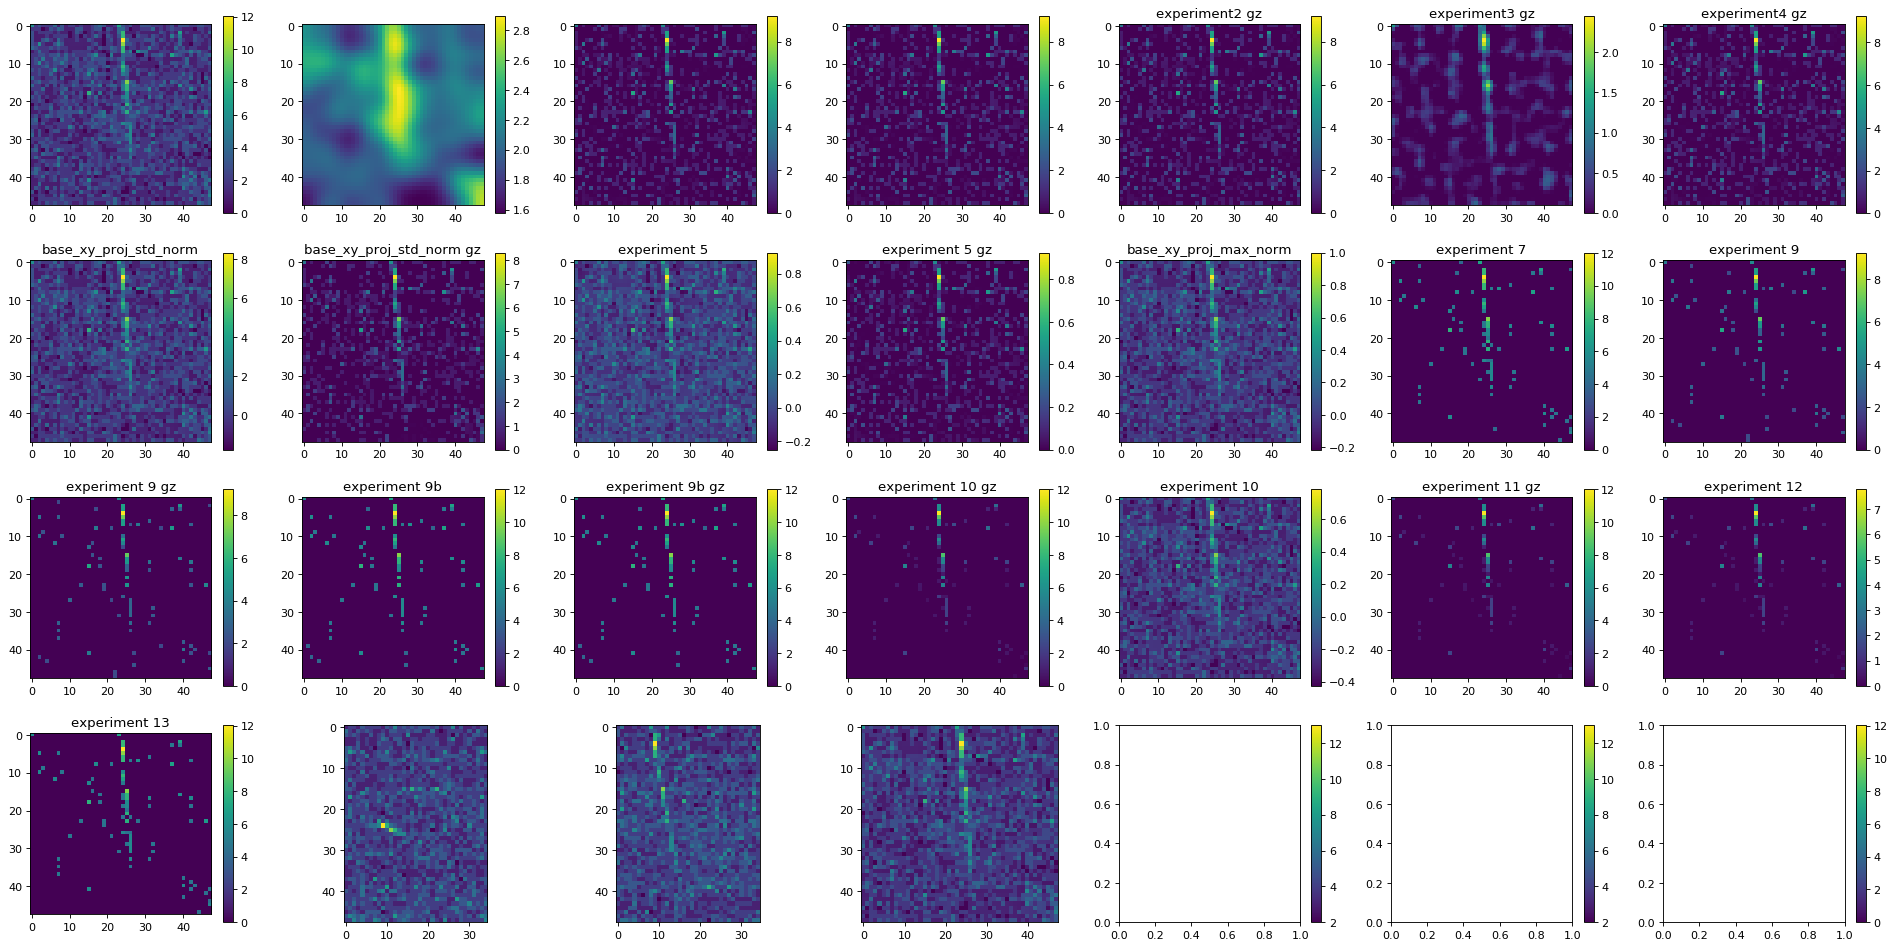

In [37]:
def threshold_yen(img):
    img_gz = np.array(img * (img>0))
    imgc_mn = img_gz - img_gz.mean()
    imgc_mn /= np.max(imgc_mn)
    img_th = img*( imgc_mn > skimage.filters.threshold_yen(imgc_mn) ) 
    return img_th
    
def threshold_mean(img):
    two_mean = 2*np.mean(img)
    return (img - 2*img) * (img > 2*np.mean(img))

mpl.rcParams['figure.dpi'] = 80

fig, axs = plt.subplots(4,7)
fig.set_size_inches(30,15)
axs_flattened = axs.flatten()
base_xy_proj = xy_projections_bgsub[n] * (xy_projections_bgsub[n]>0)

print("mean",  base_xy_proj.mean())

base_xy_proj_cent = (base_xy_proj - base_xy_proj.mean() )

print('max(abs(cent))', np.max(np.abs(base_xy_proj_cent)))

base_xy_proj_max_norm = base_xy_proj_cent/np.max(np.abs(base_xy_proj_cent))
base_xy_proj_std_norm = base_xy_proj_cent/np.std(base_xy_proj_cent)

print(base_xy_proj_max_norm)

experiment = base_xy_proj
experiment = experiment - scipy.ndimage.filters.gaussian_filter(experiment,3) #
experiment2 = experiment - scipy.ndimage.filters.gaussian_filter(experiment,10) #
experiment3 = scipy.ndimage.filters.gaussian_filter(experiment,1) - scipy.ndimage.filters.gaussian_filter(experiment,3)
experiment4 = xy_projections[n] - scipy.ndimage.filters.gaussian_filter(xy_projections[n],3) # skimage.filters.gaussian_filter(xy_projections[n],1)
experiment5 = base_xy_proj_max_norm - skimage.filters.gaussian(base_xy_proj_max_norm,3)
# experiment5 = np.max(base_xy_proj)*( base_xy_proj_max_norm * ( base_xy_proj_max_norm > skimage.filters.threshold_isodata(base_xy_proj_max_norm*(base_xy_proj_max_norm>0))  ) )  # base_xy_proj_max_norm ) # skimage.filters.gaussian(base_xy_proj_max_norm,1) - skimage.filters.gaussian(base_xy_proj_max_norm,3) )
# experiment6 = np.max(base_xy_proj)*( base_xy_proj_max_norm * ( base_xy_proj_max_norm > skimage.filters.threshold_minimum(base_xy_proj_max_norm*(base_xy_proj_max_norm>0))  ) )  # base_xy_proj_max_norm ) # skimage.filters.gaussian(base_xy_proj_max_norm,1) - skimage.filters.gaussian(base_xy_proj_max_norm,3) )
# experiment7 = np.max(base_xy_proj)*( base_xy_proj_max_norm * ( base_xy_proj_max_norm > skimage.filters.threshold_yen(base_xy_proj_max_norm*(base_xy_proj_max_norm>0))  ) )  # base_xy_proj_max_norm ) # skimage.filters.gaussian(base_xy_proj_max_norm,1) - skimage.filters.gaussian(base_xy_proj_max_norm,3) )
# experiment8 = np.max(base_xy_proj)*( base_xy_proj_max_norm * ( base_xy_proj_max_norm > skimage.filters.threshold_otsu(base_xy_proj_max_norm*(base_xy_proj_max_norm>0))  ) )  # base_xy_proj_max_norm ) # skimage.filters.gaussian(base_xy_proj_max_norm,1) - skimage.filters.gaussian(base_xy_proj_max_norm,3) )
# experiment5 = np.zeros_like(base_xy_proj) #np.max(base_xy_proj)*( (base_xy_proj_max_norm - np.min(base_xy_proj_max_norm)) * ( base_xy_proj_max_norm > skimage.filters.threshold_isodata(base_xy_proj_max_norm) ) )  # base_xy_proj_max_norm ) # skimage.filters.gaussian(base_xy_proj_max_norm,1) - skimage.filters.gaussian(base_xy_proj_max_norm,3) )
experiment6 = np.zeros_like(base_xy_proj) #np.max(base_xy_proj)*( (base_xy_proj_max_norm - np.min(base_xy_proj_max_norm)) * ( base_xy_proj_max_norm > skimage.filters.threshold_minimum(base_xy_proj_max_norm)  ) )  # base_xy_proj_max_norm ) # skimage.filters.gaussian(base_xy_proj_max_norm,1) - skimage.filters.gaussian(base_xy_proj_max_norm,3) )

experiment7 = (base_xy_proj)*( base_xy_proj_max_norm > skimage.filters.threshold_yen(base_xy_proj_max_norm)  )  # np.max(base_xy_proj)*( (base_xy_proj_max_norm - np.min(base_xy_proj_max_norm)) * ( base_xy_proj_max_norm > skimage.filters.threshold_yen(base_xy_proj_max_norm)  ) )  # base_xy_proj_max_norm ) # skimage.filters.gaussian(base_xy_proj_max_norm,1) - skimage.filters.gaussian(base_xy_proj_max_norm,3) )

experiment8 = np.zeros_like(base_xy_proj) #np.max(base_xy_proj)*( (base_xy_proj_max_norm - np.min(base_xy_proj_max_norm)) * ( base_xy_proj_max_norm > skimage.filters.threshold_otsu(base_xy_proj_max_norm)  ) )  # base_xy_proj_max_norm ) # skimage.filters.gaussian(base_xy_proj_max_norm,1) - skimage.filters.gaussian(base_xy_proj_max_norm,3) )

print(skimage.filters.threshold_yen(base_xy_proj_max_norm))

experiment4_c_max_norm = (experiment4-np.mean(experiment4))/np.max(np.abs(experiment4))
experiment9 = experiment4 * ( experiment4_c_max_norm > skimage.filters.threshold_yen( experiment4_c_max_norm) )

experiment5_c_max_norm = (experiment5-np.mean(experiment5))/np.max(np.abs(experiment5))
experiment9b = base_xy_proj * (experiment5_c_max_norm > skimage.filters.threshold_yen( experiment5_c_max_norm) )


print("np.max(base_xy_proj)",np.max(base_xy_proj))
print("np.min(base_xy_proj_max_norm)",np.min(base_xy_proj_max_norm))

experiment10 = ( (base_xy_proj_max_norm + np.min(base_xy_proj_max_norm)) ) # np.max(base_xy_proj)* #  + np.min(base_xy_proj_max_norm) is the problem
experiment11 = ( (base_xy_proj_cent + np.min(base_xy_proj_cent)) ) # np.max(base_xy_proj)* #  + np.min(base_xy_proj_max_norm) is the problem
experiment12 = (base_xy_proj - 2*np.mean(base_xy_proj)) * (base_xy_proj > 2*np.mean(base_xy_proj) ) # np.max(base_xy_proj)* #  + np.min(base_xy_proj_max_norm) is the problem
experiment13 = (base_xy_proj) * (base_xy_proj > 2*np.mean(base_xy_proj) ) # np.max(base_xy_proj)* #  + np.min(base_xy_proj_max_norm) is the problem


i=0
cax = axs_flattened[i].imshow( base_xy_proj , interpolation='none') #  * (xy_projections_bgsub[n]>0)   #  *np.ones_like(xy_projections_bgsub[n])*50 )
fig.colorbar(cax, ax=axs_flattened[i])
i += 1
cax = axs_flattened[i].imshow(  scipy.ndimage.filters.gaussian_filter(base_xy_proj,3)  , interpolation='none') #  * (xy_projections_bgsub[n]>0)   #  *np.ones_like(xy_projections_bgsub[n])*50 )
fig.colorbar(cax, ax=axs_flattened[i])
i += 1
cax = axs_flattened[i].imshow(  (experiment) * (experiment>0)  , interpolation='none') #  * (xy_projections_bgsub[n]>0)   #  *np.ones_like(xy_projections_bgsub[n])*50 )
fig.colorbar(cax, ax=axs_flattened[i])
i += 1
cax = axs_flattened[i].imshow(  (experiment+np.mean(experiment)) * (experiment>0)  , interpolation='none') #  * (xy_projections_bgsub[n]>0)   #  *np.ones_like(xy_projections_bgsub[n])*50 )
fig.colorbar(cax, ax=axs_flattened[i])
i += 1
cax = axs_flattened[i].imshow(  (experiment2) * (experiment2>0) , interpolation='none' ) #  * (xy_projections_bgsub[n]>0)   #  *np.ones_like(xy_projections_bgsub[n])*50 )
axs_flattened[i].set_title('experiment2 gz')
fig.colorbar(cax, ax=axs_flattened[i])
i += 1
cax = axs_flattened[i].imshow(  (experiment3) * (experiment3>0)  , interpolation='none') #  * (xy_projections_bgsub[n]>0)   #  *np.ones_like(xy_projections_bgsub[n])*50 )
axs_flattened[i].set_title('experiment3 gz')
fig.colorbar(cax, ax=axs_flattened[i])
i += 1
cax = axs_flattened[i].imshow(  (experiment4) * (experiment4>0)  , interpolation='none') #  * (xy_projections_bgsub[n]>0)   #  *np.ones_like(xy_projections_bgsub[n])*50 )
axs_flattened[i].set_title('experiment4 gz')
fig.colorbar(cax, ax=axs_flattened[i])
i += 1
cax = axs_flattened[i].imshow(  base_xy_proj_std_norm , interpolation='none') #  * (xy_projections_bgsub[n]>0)   #  *np.ones_like(xy_projections_bgsub[n])*50 )
axs_flattened[i].set_title('base_xy_proj_std_norm')
fig.colorbar(cax, ax=axs_flattened[i])
i += 1
cax = axs_flattened[i].imshow(  base_xy_proj_std_norm * (base_xy_proj_std_norm>0) , interpolation='none' ) #  * (xy_projections_bgsub[n]>0)   #  *np.ones_like(xy_projections_bgsub[n])*50 )
axs_flattened[i].set_title('base_xy_proj_std_norm gz')
fig.colorbar(cax, ax=axs_flattened[i])
i += 1
cax = axs_flattened[i].imshow(  experiment5  , interpolation='none') # * (experiment5>0) # * (xy_projections_bgsub[n]>0)   #  *np.ones_like(xy_projections_bgsub[n])*50 )
axs_flattened[i].set_title('experiment 5 ')
fig.colorbar(cax, ax=axs_flattened[i])
i += 1
cax = axs_flattened[i].imshow(  experiment5 * (experiment5>0) , interpolation='none' ) # * (experiment5>0) # * (xy_projections_bgsub[n]>0)   #  *np.ones_like(xy_projections_bgsub[n])*50 )
axs_flattened[i].set_title('experiment 5 gz')
fig.colorbar(cax, ax=axs_flattened[i])
i += 1
# cax = axs_flattened[i].imshow(  experiment6 * (experiment6>0)  ) #  * (xy_projections_bgsub[n]>0)   #  *np.ones_like(xy_projections_bgsub[n])*50 )
# axs_flattened[i].set_title('experiment 6 gz')
# fig.colorbar(cax, ax=axs_flattened[i])
# i += 1
cax = axs_flattened[i].imshow(  base_xy_proj_max_norm , interpolation='none' ) # * (experiment7>0)  #  * (xy_projections_bgsub[n]>0)   #  *np.ones_like(xy_projections_bgsub[n])*50 )
axs_flattened[i].set_title('base_xy_proj_max_norm')                 # cmap=plt.get_cmap('gist_rainbow')
fig.colorbar(cax, ax=axs_flattened[i])
i += 1
cax = axs_flattened[i].imshow(  experiment7 , interpolation='none' ) # * (experiment7>0)  #  * (xy_projections_bgsub[n]>0)   #  *np.ones_like(xy_projections_bgsub[n])*50 )
axs_flattened[i].set_title('experiment 7')                 # cmap=plt.get_cmap('gist_rainbow')
fig.colorbar(cax, ax=axs_flattened[i])
i += 1
# cax = axs_flattened[i].imshow( experiment8 * (experiment8>0), cmap=plt.get_cmap('gist_rainbow')  ) #  * (xy_projections_bgsub[n]>0)   #  *np.ones_like(xy_projections_bgsub[n])*50 )
# axs_flattened[i].set_title('experiment 8 gz') # (np.max(experiment7) / np.max(experiment8)) *  
# fig.colorbar(cax, ax=axs_flattened[i])
# i += 1
cax = axs_flattened[i].imshow( experiment9 , interpolation='none'   ) #(n p.max(experiment7) / np.max(experiment9)) * #  * (xy_projections_bgsub[n]>0)   #  *np.ones_like(xy_projections_bgsub[n])*50 )
axs_flattened[i].set_title('experiment 9')                 # cmap=plt.get_cmap('gist_rainbow')
fig.colorbar(cax, ax=axs_flattened[i])
i += 1
cax = axs_flattened[i].imshow(  experiment9 * (experiment9>0), interpolation='none'  ) #(np.max(experiment7) / np.max(experiment9)) * #  * (xy_projections_bgsub[n]>0)   #  *np.ones_like(xy_projections_bgsub[n])*50 )
axs_flattened[i].set_title('experiment 9 gz')                 # cmap=plt.get_cmap('gist_rainbow')
fig.colorbar(cax, ax=axs_flattened[i])
i += 1

cax = axs_flattened[i].imshow( experiment9b , interpolation='none'   ) #(n p.max(experiment7) / np.max(experiment9)) * #  * (xy_projections_bgsub[n]>0)   #  *np.ones_like(xy_projections_bgsub[n])*50 )
axs_flattened[i].set_title('experiment 9b')                 # cmap=plt.get_cmap('gist_rainbow')
fig.colorbar(cax, ax=axs_flattened[i])
i += 1
cax = axs_flattened[i].imshow(  experiment9b * (experiment9b>0), interpolation='none'   ) #(np.max(experiment7) / np.max(experiment9)) * #  * (xy_projections_bgsub[n]>0)   #  *np.ones_like(xy_projections_bgsub[n])*50 )
axs_flattened[i].set_title('experiment 9b gz')                 # cmap=plt.get_cmap('gist_rainbow')
fig.colorbar(cax, ax=axs_flattened[i])
i += 1

cax = axs_flattened[i].imshow( (np.max(experiment7) / np.max(experiment10)) * experiment10 * (experiment10>0) , interpolation='none' ) #  * (xy_projections_bgsub[n]>0)   #  *np.ones_like(xy_projections_bgsub[n])*50 )
axs_flattened[i].set_title('experiment 10 gz')
fig.colorbar(cax, ax=axs_flattened[i])
i += 1
cax = axs_flattened[i].imshow(experiment10 , interpolation='none') # (np.max(experiment7) / np.max(experiment10)) *  experiment10  ) #  * (xy_projections_bgsub[n]>0)   #  *np.ones_like(xy_projections_bgsub[n])*50 )
axs_flattened[i].set_title('experiment 10')
fig.colorbar(cax, ax=axs_flattened[i])
i += 1
cax = axs_flattened[i].imshow( (np.max(experiment7) / np.max(experiment11)) *  experiment11 * (experiment11 > 0) , interpolation='none' ) #  * (xy_projections_bgsub[n]>0)   #  *np.ones_like(xy_projections_bgsub[n])*50 )
axs_flattened[i].set_title('experiment 11 gz')
fig.colorbar(cax, ax=axs_flattened[i])
i += 1
cax = axs_flattened[i].imshow(  experiment12 , interpolation='none' ) #  (np.max(experiment7) / np.max(experiment12)) * # * (xy_projections_bgsub[n]>0)   #  *np.ones_like(xy_projections_bgsub[n])*50 )
axs_flattened[i].set_title('experiment 12')
fig.colorbar(cax, ax=axs_flattened[i])
i += 1
cax = axs_flattened[i].imshow( (np.max(experiment7) / np.max(experiment13)) *  experiment13 , interpolation='none' ) #  * (xy_projections_bgsub[n]>0)   #  *np.ones_like(xy_projections_bgsub[n])*50 )
axs_flattened[i].set_title('experiment 13')
fig.colorbar(cax, ax=axs_flattened[i])
i += 1
# cax = axs_flattened[i].imshow(  experiment5 * (experiment5>0)  ) #  * (xy_projections_bgsub[n]>0)   #  *np.ones_like(xy_projections_bgsub[n])*50 )
# fig.colorbar(cax, ax=axs_flattened[i])
# i += 1

# i += 1

cax = axs_flattened[i].imshow(gtux_projections_bgsub[n] * (gtux_projections_bgsub[n]>0), interpolation='none')
fig.colorbar(cax, ax=axs_flattened[-3])
i += 1
cax = axs_flattened[i].imshow(gtuy_projections_bgsub[n] * (gtuy_projections_bgsub[n]>0), interpolation='none')
fig.colorbar(cax, ax=axs_flattened[-2])
i += 1
cax = axs_flattened[i].imshow(xy_projections_bgsub[n] * (xy_projections_bgsub[n]>0), interpolation='none')
fig.colorbar(cax, ax=axs_flattened[-1])
plt.show()

skimage.filters.thresholding.threshold_triangle
skimage.filters.thresholding.threshold_isodata
skimage.filters.thresholding.threshold_minimum
skimage.filters.thresholding.threshold_mean
skimage.filters.thresholding.threshold_otsu
skimage.filters.thresholding.threshold_li
skimage.filters.thresholding.threshold_yen


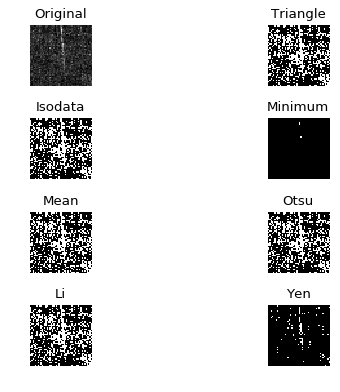

In [38]:
# print(skimage.filters.threshold_isodata(base_xy_proj_max_norm*(base_xy_proj_max_norm>0)))
# print(skimage.filters.threshold_triangle(base_xy_proj_max_norm*(base_xy_proj_max_norm>0)))
# fig, ax = skimage.filters.try_all_threshold(base_xy_proj_max_norm*(base_xy_proj_max_norm>0))
fig, ax = skimage.filters.try_all_threshold(base_xy_proj_max_norm)
plt.show()

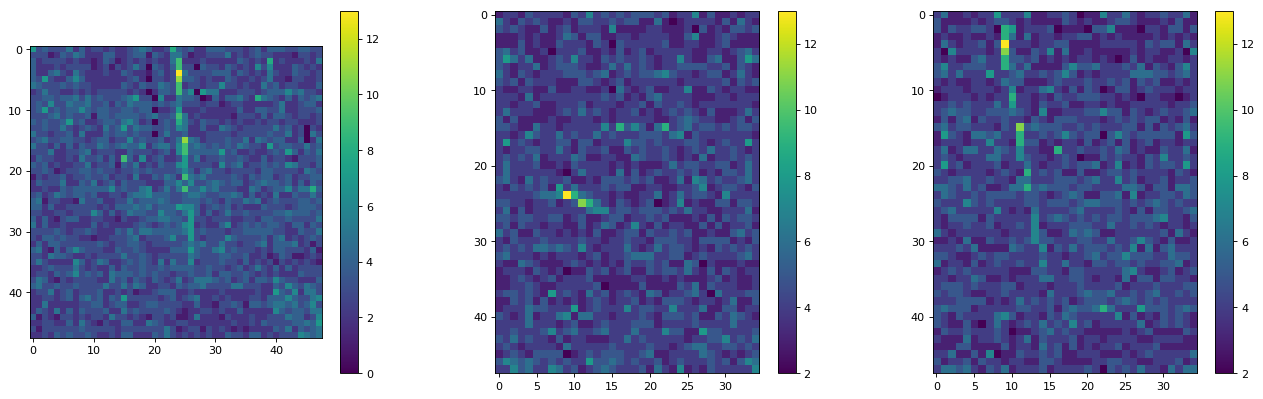

In [39]:
fig, axs = plt.subplots(1,3)
fig.set_size_inches(20,6)
axs_flattened = axs.flatten()
cax = axs_flattened[0].imshow(xy_projections[n])
fig.colorbar(cax, ax=axs_flattened[0])
cax = axs_flattened[1].imshow(gtux_projections[n])
fig.colorbar(cax, ax=axs_flattened[1])
cax = axs_flattened[2].imshow(gtuy_projections[n])
fig.colorbar(cax, ax=axs_flattened[2])
plt.show()

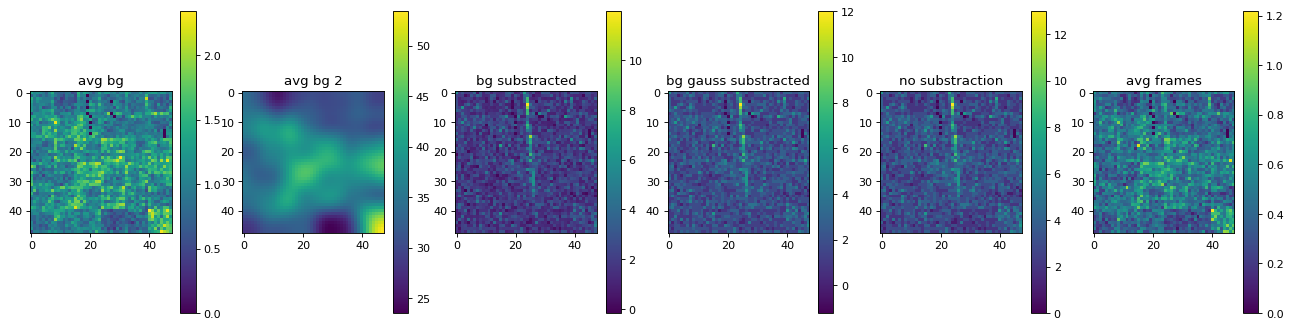

In [89]:
fig, axs = plt.subplots(1,6)
fig.set_size_inches(20,5)
axs_flattened = axs.flatten()

bgframes_offset = 0
bgframes_length = 32
gaussian_filter_sigma = 2

# 

for i, r in enumerate(visible_showers):

    if i != n:
        continue
    elif i > n:
        continue
    
    event_id, packet_id, gtu_in_packet, num_gtu, acquisition_file = r
    gtu_in_packet_corrected = max(gtu_in_packet - 4, 0)

    if gtu_in_packet_corrected + num_gtu < 30:
        print('#{}  ID {}  gtu_in_packet + num_gtu - 4 < 30'.format(i, event_id))
        continue

    if acquisition_file.endswith('.npy'):
        acquisition_arr = np.load(acquisition_file)[packet_id * 128:packet_id*128+128]
        npy_clear_background = np.load(acquisition_file)[gtu_in_packet_corrected:gtu_in_packet_corrected + num_gtu]
#             frames_acquisition = acquisition_arr[gtu_in_packet_corrected:packet_id * 128 + gtu_in_packet_corrected + num_gtu]                
    elif acquisition_file.endswith('.root'):
        acquisition_arr = tool.acqconv.get_frames(acquisition_file,
                                                     packet_id * 128 ,
                                                     packet_id * 128 + 127, 
                                                     entry_is_gtu_optimization=True)

    frames_acquisition = acquisition_arr[gtu_in_packet_corrected:gtu_in_packet_corrected + num_gtu]

#     if substract_bg:
    avg_frames_background = np.add.reduce(acquisition_arr[bgframes_offset:bgframes_offset+bgframes_length])/min(bgframes_length,len(acquisition_arr[bgframes_offset:]))
    frames_background = acquisition_arr[bgframes_offset:bgframes_offset+bgframes_length]
        
    if True:
        avg_frames_background_gauss = scipy.ndimage.filters.gaussian_filter(avg_frames_background, gaussian_filter_sigma)

    cax = axs_flattened[0].imshow(avg_frames_background, interpolation='none')
    axs_flattened[0].set_title('avg bg')
    fig.colorbar(cax, ax=axs_flattened[0])

    avg_frames_background_2 = np.zeros((32,48,48))
    
    for i in range(bgframes_offset,bgframes_offset+bgframes_length):
        avg_frames_background_2[i] = scipy.ndimage.filters.gaussian_filter(acquisition_arr[i], 3)

    cax = axs_flattened[1].imshow(np.add.reduce(avg_frames_background_2), interpolation='none')
    axs_flattened[1].set_title('avg bg 2')
    fig.colorbar(cax, ax=axs_flattened[1])
        
    frames_acquisition = frames_acquisition.astype(np.float32)

    cax = axs_flattened[2].imshow(np.maximum.reduce(frames_acquisition) - avg_frames_background, interpolation='none')
    axs_flattened[2].set_title('bg substracted')
    fig.colorbar(cax, ax=axs_flattened[2])

    cax = axs_flattened[3].imshow(np.maximum.reduce(frames_acquisition) - avg_frames_background_gauss, interpolation='none')
    axs_flattened[3].set_title('bg gauss substracted')
    fig.colorbar(cax, ax=axs_flattened[3])
    
    cax = axs_flattened[4].imshow(np.maximum.reduce(frames_acquisition), interpolation='none')
    axs_flattened[4].set_title('no substraction')
    fig.colorbar(cax, ax=axs_flattened[4])
    
    cax = axs_flattened[5].imshow(np.add.reduce(frames_acquisition)/bgframes_length, interpolation='none')
    axs_flattened[5].set_title('avg frames')
    fig.colorbar(cax, ax=axs_flattened[5])
    

#     for frame in frames_acquisition:
#         frame -= avg_frames_background

#     xy_proj = np.maximum.reduce(frames_acquisition)

#     gtuy_proj = []
#     for frame in acquisition_arr[packet_simu_data_gtu_offset:packet_simu_data_gtu_offset+packet_simu_sequence_length]:
#         gtuy_proj.append(np.max(frame, axis=1).reshape(-1, 1))  # max in the x axis
#     gtuy_proj = np.hstack(gtuy_proj)

#     gtux_proj = []
#     for frame in acquisition_arr[packet_simu_data_gtu_offset:packet_simu_data_gtu_offset+packet_simu_sequence_length]:
#         gtux_proj.append(np.max(frame, axis=0).reshape(-1, 1))  # max the y axis
#     gtux_proj = np.hstack(gtux_proj)

plt.show()

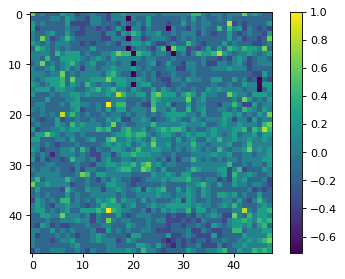

In [41]:
bg_xy_proj = np.maximum.reduce(frames_background)
bg_xy_proj_cent = bg_xy_proj - np.mean(bg_xy_proj)
bg_xy_proj_cent_max_norm = bg_xy_proj_cent/np.max(np.abs(bg_xy_proj_cent))
bg_xy_proj_cent_std_norm = bg_xy_proj_cent/np.std(bg_xy_proj_cent)
cax = plt.imshow(bg_xy_proj_cent_max_norm)
plt.colorbar(cax)
plt.show()

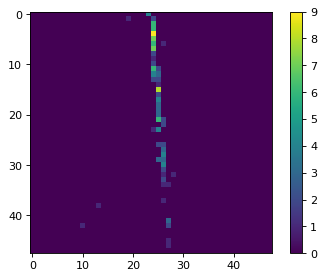

In [42]:
xy_proj_m_bg_xy_proj = np.maximum.reduce(frames_acquisition) - bg_xy_proj
cax = plt.imshow(xy_proj_m_bg_xy_proj * (xy_proj_m_bg_xy_proj>0), interpolation='none')
plt.colorbar(cax)
plt.show()

In [43]:
def binaryim(img):
    return (img > 0).astype(np.int0)

def get_neighbour_values(img, i, j, default_val=0):
    A0 = img[i,j]
    A1 = A2 = A3 = A4 = A5 = A6 = A7 = A8 = default_val
    if i > 0:
        A3 = img[i-1,j]
        if j > 0:
            A4 = img[i,j-1]
        if j < img.shape[0]-1:
            A2 = img[i,j+1]
    if i < img.shape[1]-1:
        A7 = img[i+1,j]
        if j > 0:
            A6 = img[i,j-1]
        if j < img.shape[0]-1:
            A8 = img[i,j+1]
    if j > 0:
        A5 = img[i,j-1]
    if j < img.shape[0]-1:
        A1 = img[i,j+1]
    return A0, A1, A2, A3, A4, A5, A6, A7, A8 
    
def binarythinim(img):
    ibimg = binaryim(img)
    obimg = np.zeros_like(img, dtype=np.int8)
    for i in range(ibimg.shape[0]):
        for j in range(ibimg.shape[1]):
            A0, A1, A2, A3, A4, A5, A6, A7, A8 = get_neighbour_values(ibimg,i,j)
            sigma = A1 + A2 + A3 + A4 + A5 + A6 + A7 + A8;
            if sigma < 8:
                obimg[i,j] = 0
            else:
                obimg[i, j] = A0
    return obimg 

def removesaltim(img):
    ibimg = binaryim(img)
    obimg = np.zeros_like(img, dtype=np.int8)
    for i in range(ibimg.shape[0]):
        for j in range(ibimg.shape[1]):
            A0, A1, A2, A3, A4, A5, A6, A7, A8 = get_neighbour_values(ibimg,i,j)
            sigma = A1 + A2 + A3 + A4 + A5 + A6 + A7 + A8;
            if sigma == 8:
                obimg[i,j] = 1
            else:
                obimg[i, j] = A0
    return obimg

def removepepperim(img):
    ibimg = binaryim(img)
    obimg = np.zeros_like(img, dtype=np.int8)
    for i in range(ibimg.shape[0]):
        for j in range(ibimg.shape[1]):
            A0, A1, A2, A3, A4, A5, A6, A7, A8 = get_neighbour_values(ibimg,i,j)
            sigma = A1 + A2 + A3 + A4 + A5 + A6 + A7 + A8;
            if sigma == 0:
                obimg[i,j] = 0
            else:
                obimg[i, j] = A0
    return obimg

def removesaltpepperim(img):
    ibimg = binaryim(img)
    obimg = np.zeros_like(img, dtype=np.int8)
    for i in range(ibimg.shape[0]):
        for j in range(ibimg.shape[1]):
            A0, A1, A2, A3, A4, A5, A6, A7, A8 = get_neighbour_values(ibimg,i,j)
            sigma = A1 + A2 + A3 + A4 + A5 + A6 + A7 + A8;
            if sigma == 0:
                obimg[i,j] = 0
            elif sigma == 8:
                obimg[i,j] = 1
            else:
                obimg[i, j] = A0
    return obimg

In [116]:
np.savetxt('/tmp/ntbout_event_xy_projection_{:d}.txt'.format(n), xy_projections[n], fmt='%.4f')
np.savetxt('/tmp/ntbout_event_xy_projection_{:d}_minus_avg_bg.txt'.format(n), xy_projections[n] - avg_frames_background, fmt='%.4f')
np.savetxt('/tmp/ntbout_event_xy_projection_{:d}_gz.txt'.format(n), xy_projections[n] * (xy_projections[n] > 0), fmt='%.4f')
np.savetxt('/tmp/ntbout_event_xy_projection_{:d}_minus_avg_bg_gz.txt'.format(n), xy_projections[n] - avg_frames_background * ((xy_projections[n] - avg_frames_background) > 0), fmt='%.4f')

In [226]:
def bimodtest(y):
    l = len(y)
    b = False
    modes = 0
    
    for k in range(1,l-1):
        if y[k-1] < y[k] and y[k+1] < y[k]:
            
#             print(modes, k, y[k-1], y[k], y[k+1])
            
            modes += 1
            if modes > 2:
#                 print("Num modes > 2")
                return False
                # return b
                #break
    
#     print("Num modes", modes)
    
    if modes == 2:
#         print("bimodtest is true")
        b = True
    
        
    return b

def th_intermodes(I, n=None):
    if n is None:
#         n = 255
        n = int(np.max(I))+1
#     I = I.astype(np.float64) 
    I_f = I.flatten()
    y, bin_edges = np.histogram(I_f, n, density=False)
#     y *= len(I_f)
    
    iter_ = 0
    while not bimodtest(y):
    
#         print("****************")
#         h = np.ones((1,3))/3
        h = np.ones(3)/3
#         y = scipy.signal.convolve2d(y, h, 'same')
        y = np.convolve(y, h, 'same')
#         print(y)
        iter_ += 1
        if iter_ > 10000:
            #T = 0
            return 0
            # return T
        
#         print("****************")
        
#     return iter_
    
    TT = []
#     print(n)
    
#     ind = 0
    for k in range(1,n-1):
        if y[k-1] < y[k] and y[k+1] < y[k]:
            TT.append(k)
#             ind += 1
    
#     print(TT)
    
    return np.floor(np.mean(TT))

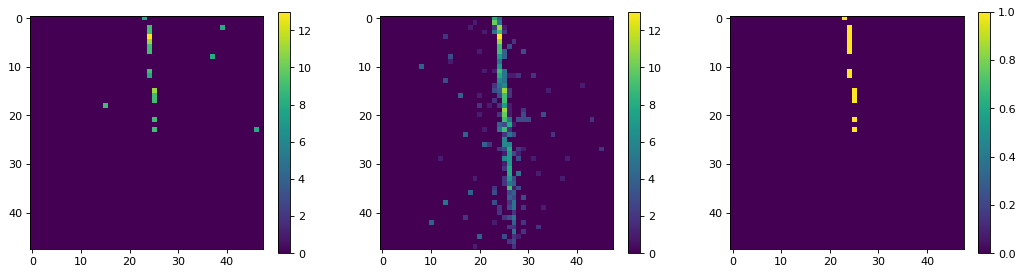

In [240]:
# th_intermodes(xy_projections[n])
plt.close('all')
fig, axs = plt.subplots(1,3)
fig.set_size_inches(16,4)
axs_flattened = axs.flatten()
i=0
cax = axs_flattened[i].imshow(xy_projections[n] * (xy_projections[n] > th_intermodes(xy_projections[n])))
fig.colorbar(cax, ax=axs_flattened[i])
i += 1
cax = axs_flattened[i].imshow(simu_xy_projections[n])
fig.colorbar(cax, ax=axs_flattened[i])
i += 1
cax = axs_flattened[i].imshow(simu_xy_projections[n].astype(np.bool) * (xy_projections[n] * (xy_projections[n] > th_intermodes(xy_projections[n]))).astype(np.bool))
fig.colorbar(cax, ax=axs_flattened[i])
i += 1
plt.show()

In [285]:
def thresholding_effciency(simu_projection, with_noise_projection, thresholded_projection):
    intersection = simu_projection.astype(np.bool) * thresholded_projection.astype(np.bool)
    count_nonzero_thresholded = np.count_nonzero(thresholded_projection)
    count_nonzero_simu = np.count_nonzero(simu_projection)
    count_nonzero_background = np.count_nonzero(with_noise_projection) - count_nonzero_simu
    num_valid = np.count_nonzero(intersection)
    num_invalid = count_nonzero_thresholded - num_valid
    num_valid_to_invalid = num_valid/num_invalid if num_invalid > 0 else np.inf
    num_valid_to_count_nonzero_simu = num_valid/count_nonzero_simu if count_nonzero_simu > 0 else np.inf
    num_valid_to_count_nonzero_thresholded = num_valid/count_nonzero_thresholded if count_nonzero_thresholded > 0 else np.inf
    num_invalid_to_count_nonzero_thresholded = num_invalid/count_nonzero_thresholded if count_nonzero_thresholded > 0 else np.inf
    num_invalid_to_count_nonzero_background = num_invalid/count_nonzero_background if count_nonzero_background > 0 else np.inf
    return num_valid, num_invalid, \
           num_valid_to_invalid, num_valid_to_count_nonzero_simu, \
           num_valid_to_count_nonzero_thresholded, num_invalid_to_count_nonzero_thresholded, \
           num_invalid_to_count_nonzero_background

In [313]:
thresholding_effciency(simu_xy_projections[n], xy_projections[n], xy_projections[n] * (xy_projections[n] > th_intermodes(xy_projections[n])))

(14,
 4,
 3.5,
 0.08139534883720931,
 0.7777777777777778,
 0.2222222222222222,
 0.0018876828692779614)

threshold_triangle 3.07226555398
(99, 694, 0.14265129682997119, 0.5755813953488372, 0.12484237074401008, 0.8751576292559899, 0.32751297781972627)
threshold_triangle 2.59478759766
(85, 533, 0.15947467166979362, 0.4941860465116279, 0.13754045307443366, 0.8624595469255664, 0.2516525023607177)
threshold_isodata 2.81835930826
(148, 1509, 0.09807819748177601, 0.8604651162790697, 0.08931804465902234, 0.9106819553409776, 0.7121283624351109)
threshold_isodata 2.45452880859
(91, 594, 0.1531986531986532, 0.5290697674418605, 0.13284671532846715, 0.8671532846715329, 0.2804532577903683)
threshold_minimum 10.6386716764
(3, 0, inf, 0.01744186046511628, 1.0, 0.0, 0.0)
threshold_minimum 9.37396240234
(3, 0, inf, 0.01744186046511628, 1.0, 0.0, 0.0)
threshold_yen 6.01757800431
(23, 18, 1.2777777777777777, 0.13372093023255813, 0.5609756097560976, 0.43902439024390244, 0.008494572911750826)
threshold_yen 4.32464599609
(30, 38, 0.7894736842105263, 0.1744186046511628, 0.4411764705882353, 0.5588235294117647, 0.

threshold_sauvola [[ 2.11747705  2.09179383  2.08119195 ...,  1.96054372  1.93570538
   1.85263292]
 [ 2.15790267  2.12555738  2.11483571 ...,  1.9663358   1.93051189
   1.84400443]
 [ 2.17141217  2.1413166   2.12899059 ...,  1.97402924  1.96073672
   1.87354977]
 ..., 
 [ 1.8678095   1.92152351  1.90054232 ...,  2.32036911  2.34559355
   2.39232719]
 [ 1.8604907   1.91882128  1.89679925 ...,  2.34955772  2.37429119
   2.40878367]
 [ 1.83605242  1.8997427   1.87238547 ...,  2.3373896   2.36170252
   2.40289307]]
(102, 918, 0.1111111111111111, 0.5930232558139535, 0.1, 0.9, 0.43342776203966005)


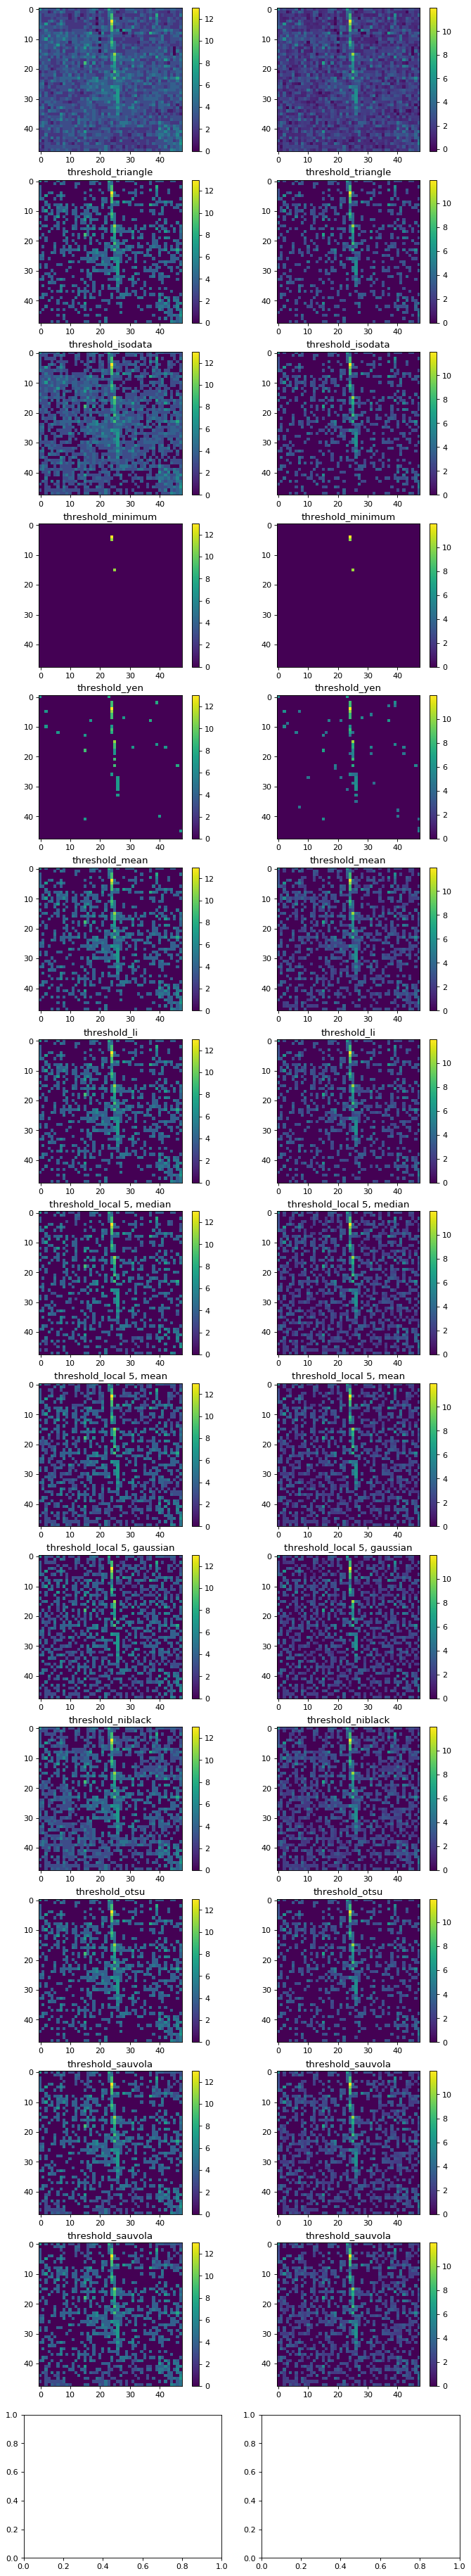

In [289]:
def apply_threshold(img, func, gz=True, norm_out=True):
    if gz:
        img_gz = np.array(img * (img>0))
    else:
        img_gz = img
    imgc_mn = img_gz - img_gz.mean()
    max_before_norm = np.max(np.abs(imgc_mn))
    imgc_mn /= max_before_norm
    thr_val = func(imgc_mn)
    if not norm_out:
#         print("  thr_val = {}  max_before_norm = {}  img_gz.mean()= {}".format(thr_val, max_before_norm, img_gz.mean()))
        img_th = img*( imgc_mn > thr_val ) 
        thr_val = thr_val * max_before_norm + img_gz.mean()
    else:
        img_th = imgc_mn*( imgc_mn > thr_val )
    return img_th, thr_val

plt.close('all')

mpl.rcParams['figure.dpi'] = 80

cols = 2
rows = 15
fig, axs = plt.subplots(rows,cols)
fig.set_size_inches(cols*5,rows*4)
axs_flattened = axs.flatten()
i=0
cax = axs_flattened[i].imshow(xy_projections[n])
fig.colorbar(cax, ax=axs_flattened[i])
i += 1
cax = axs_flattened[i].imshow(xy_projections[n] - avg_frames_background)
fig.colorbar(cax, ax=axs_flattened[i])
i += 1

gz = True
norm_out = False

thr_img, thr_val = apply_threshold(xy_projections[n], skimage.filters.threshold_triangle, gz, norm_out)
cax = axs_flattened[i].imshow(thr_img)
axs_flattened[i].set_title("threshold_triangle")
fig.colorbar(cax, ax=axs_flattened[i])
print("threshold_triangle", thr_val)
print(thresholding_effciency(simu_xy_projections[n], xy_projections[n], thr_img))
i += 1
thr_img, thr_val = apply_threshold(xy_projections[n] - avg_frames_background, skimage.filters.threshold_triangle, gz, norm_out)
cax = axs_flattened[i].imshow(thr_img)
axs_flattened[i].set_title("threshold_triangle")
fig.colorbar(cax, ax=axs_flattened[i])
print("threshold_triangle", thr_val)
print(thresholding_effciency(simu_xy_projections[n], xy_projections[n] - avg_frames_background, thr_img))
i += 1

thr_img, thr_val = apply_threshold(xy_projections[n], skimage.filters.threshold_isodata, gz, norm_out)
cax = axs_flattened[i].imshow(thr_img)
axs_flattened[i].set_title("threshold_isodata")
fig.colorbar(cax, ax=axs_flattened[i])
print("threshold_isodata", thr_val)
print(thresholding_effciency(simu_xy_projections[n], xy_projections[n], thr_img))
i += 1
thr_img, thr_val = apply_threshold(xy_projections[n] - avg_frames_background, skimage.filters.threshold_isodata, gz, norm_out)
cax = axs_flattened[i].imshow(thr_img)
axs_flattened[i].set_title("threshold_isodata")
fig.colorbar(cax, ax=axs_flattened[i])
print("threshold_isodata", thr_val)
print(thresholding_effciency(simu_xy_projections[n], xy_projections[n] - avg_frames_background, thr_img))
i += 1

thr_img, thr_val = apply_threshold(xy_projections[n], skimage.filters.threshold_minimum, gz, norm_out)
cax = axs_flattened[i].imshow(thr_img)
axs_flattened[i].set_title("threshold_minimum")
fig.colorbar(cax, ax=axs_flattened[i])
print("threshold_minimum", thr_val)
print(thresholding_effciency(simu_xy_projections[n], xy_projections[n], thr_img))
i += 1
thr_img, thr_val = apply_threshold(xy_projections[n] - avg_frames_background, skimage.filters.threshold_minimum, gz, norm_out)
cax = axs_flattened[i].imshow(thr_img)
axs_flattened[i].set_title("threshold_minimum")
fig.colorbar(cax, ax=axs_flattened[i])
print("threshold_minimum", thr_val)
print(thresholding_effciency(simu_xy_projections[n], xy_projections[n] - avg_frames_background, thr_img))
i += 1

thr_img, thr_val = apply_threshold(xy_projections[n], skimage.filters.threshold_yen, gz, norm_out)
cax = axs_flattened[i].imshow(thr_img)
axs_flattened[i].set_title("threshold_yen")
fig.colorbar(cax, ax=axs_flattened[i])
print("threshold_yen", thr_val)
print(thresholding_effciency(simu_xy_projections[n], xy_projections[n], thr_img))
i += 1
thr_img, thr_val = apply_threshold(xy_projections[n] - avg_frames_background, skimage.filters.threshold_yen, gz, norm_out)
cax = axs_flattened[i].imshow(thr_img)
axs_flattened[i].set_title("threshold_yen")
fig.colorbar(cax, ax=axs_flattened[i])
print("threshold_yen", thr_val)
print(thresholding_effciency(simu_xy_projections[n], xy_projections[n] - avg_frames_background, thr_img))
i += 1

thr_img, thr_val = apply_threshold(xy_projections[n], skimage.filters.threshold_mean, gz, norm_out)
cax = axs_flattened[i].imshow(thr_img)
axs_flattened[i].set_title("threshold_mean")
fig.colorbar(cax, ax=axs_flattened[i])
print("threshold_mean", thr_val)
print(thresholding_effciency(simu_xy_projections[n], xy_projections[n], thr_img))
i += 1
thr_img, thr_val = apply_threshold(xy_projections[n] - avg_frames_background, skimage.filters.threshold_mean, gz, norm_out)
cax = axs_flattened[i].imshow(thr_img)
axs_flattened[i].set_title("threshold_mean")
fig.colorbar(cax, ax=axs_flattened[i])
print("threshold_mean", thr_val)
print(thresholding_effciency(simu_xy_projections[n], xy_projections[n] - avg_frames_background, thr_img))
i += 1

thr_img, thr_val = apply_threshold(xy_projections[n], skimage.filters.threshold_li, gz, norm_out)
cax = axs_flattened[i].imshow(thr_img)
axs_flattened[i].set_title("threshold_li")
fig.colorbar(cax, ax=axs_flattened[i])
print("threshold_li", thr_val)
print(thresholding_effciency(simu_xy_projections[n], xy_projections[n], thr_img))
i += 1
thr_img, thr_val = apply_threshold(xy_projections[n] - avg_frames_background, skimage.filters.threshold_li, gz, norm_out)
cax = axs_flattened[i].imshow(thr_img)
axs_flattened[i].set_title("threshold_li")
fig.colorbar(cax, ax=axs_flattened[i])
print("threshold_li", thr_val)
print(thresholding_effciency(simu_xy_projections[n], xy_projections[n] - avg_frames_background, thr_img))
i += 1

nbgh = 5

thr_img, thr_val = apply_threshold(xy_projections[n], lambda img: skimage.filters.threshold_local(img, nbgh, method='median'), gz, norm_out)
cax = axs_flattened[i].imshow(thr_img)
axs_flattened[i].set_title("threshold_local {}, median".format(nbgh))
fig.colorbar(cax, ax=axs_flattened[i])
print("threshold_local {}, median".format(nbgh), thr_val)
print(thresholding_effciency(simu_xy_projections[n], xy_projections[n], thr_img))
i += 1
thr_img, thr_val = apply_threshold(xy_projections[n] - avg_frames_background, lambda img: skimage.filters.threshold_local(img, nbgh, method='median'), gz, norm_out)
cax = axs_flattened[i].imshow(thr_img)
axs_flattened[i].set_title("threshold_local {}, median".format(nbgh))
fig.colorbar(cax, ax=axs_flattened[i])
print("threshold_local {}, median".format(nbgh), thr_val)
print(thresholding_effciency(simu_xy_projections[n], xy_projections[n] - avg_frames_background, thr_img))
i += 1

thr_img, thr_val = apply_threshold(xy_projections[n], lambda img: skimage.filters.threshold_local(img, nbgh, method='mean'), gz, norm_out)
cax = axs_flattened[i].imshow(thr_img)
axs_flattened[i].set_title("threshold_local {}, mean".format(nbgh))
fig.colorbar(cax, ax=axs_flattened[i])
print("threshold_local {}, mean".format(nbgh), thr_val)
print(thresholding_effciency(simu_xy_projections[n], xy_projections[n], thr_img))
i += 1
thr_img, thr_val = apply_threshold(xy_projections[n] - avg_frames_background, lambda img: skimage.filters.threshold_local(img, nbgh, method='mean'), gz, norm_out)
cax = axs_flattened[i].imshow(thr_img)
axs_flattened[i].set_title("threshold_local {}, mean".format(nbgh))
fig.colorbar(cax, ax=axs_flattened[i])
print("threshold_local {}, mean".format(nbgh), thr_val)
print(thresholding_effciency(simu_xy_projections[n], xy_projections[n] - avg_frames_background, thr_img))
i += 1

thr_img, thr_val = apply_threshold(xy_projections[n], lambda img: skimage.filters.threshold_local(img, nbgh, method='gaussian'), gz, norm_out)
cax = axs_flattened[i].imshow(thr_img)
axs_flattened[i].set_title("threshold_local {}, gaussian".format(nbgh))
fig.colorbar(cax, ax=axs_flattened[i])
print("threshold_local {}, gaussian".format(nbgh), thr_val)
print(thresholding_effciency(simu_xy_projections[n], xy_projections[n], thr_img))
i += 1
thr_img, thr_val = apply_threshold(xy_projections[n] - avg_frames_background, lambda img: skimage.filters.threshold_local(img, nbgh, method='gaussian'), gz, norm_out)
cax = axs_flattened[i].imshow(thr_img)
axs_flattened[i].set_title("threshold_local {}, gaussian".format(nbgh))
fig.colorbar(cax, ax=axs_flattened[i])
print("threshold_local {}, gaussian".format(nbgh), thr_val)
print(thresholding_effciency(simu_xy_projections[n], xy_projections[n] - avg_frames_background, thr_img))
i += 1

# cax = axs_flattened[i].imshow(apply_threshold(xy_projections[n], lambda img: skimage.filters.threshold_local(img, method='generic'), gz))
# axs_flattened[i].set_title("threshold_local generic")
# fig.colorbar(cax, ax=axs_flattened[i])
# i += 1
# cax = axs_flattened[i].imshow(apply_threshold(xy_projections[n] - avg_frames_background, lambda img: skimage.filters.threshold_local(img, method='generic'), gz))
# axs_flattened[i].set_title("threshold_local generic")
# fig.colorbar(cax, ax=axs_flattened[i])
# i += 1


thr_img, thr_val = apply_threshold(xy_projections[n], skimage.filters.threshold_niblack, gz, norm_out)
cax = axs_flattened[i].imshow(thr_img)
axs_flattened[i].set_title("threshold_niblack")
fig.colorbar(cax, ax=axs_flattened[i])
print("threshold_niblack", thr_val)
print(thresholding_effciency(simu_xy_projections[n], xy_projections[n], thr_img))
i += 1
thr_img, thr_val = apply_threshold(xy_projections[n] - avg_frames_background, skimage.filters.threshold_niblack, gz, norm_out)
cax = axs_flattened[i].imshow(thr_img)
axs_flattened[i].set_title("threshold_niblack")
fig.colorbar(cax, ax=axs_flattened[i])
print("threshold_niblack", thr_val)
print(thresholding_effciency(simu_xy_projections[n], xy_projections[n] - avg_frames_background, thr_img))
i += 1

thr_img, thr_val = apply_threshold(xy_projections[n], skimage.filters.threshold_otsu, gz, norm_out)
cax = axs_flattened[i].imshow(thr_img)
axs_flattened[i].set_title("threshold_otsu")
fig.colorbar(cax, ax=axs_flattened[i])
print("threshold_otsu", thr_val)
print(thresholding_effciency(simu_xy_projections[n], xy_projections[n], thr_img))
i += 1
thr_img, thr_val = apply_threshold(xy_projections[n] - avg_frames_background, skimage.filters.threshold_otsu, gz, norm_out)
cax = axs_flattened[i].imshow(thr_img)
axs_flattened[i].set_title("threshold_otsu")
fig.colorbar(cax, ax=axs_flattened[i])
print("threshold_otsu", thr_val)
print(thresholding_effciency(simu_xy_projections[n], xy_projections[n] - avg_frames_background, thr_img))
i += 1

thr_img, thr_val = apply_threshold(xy_projections[n], skimage.filters.threshold_sauvola, gz, norm_out)
cax = axs_flattened[i].imshow(thr_img)
axs_flattened[i].set_title("threshold_sauvola")
fig.colorbar(cax, ax=axs_flattened[i])
print("threshold_sauvola", thr_val)
print(thresholding_effciency(simu_xy_projections[n], xy_projections[n], thr_img))
i += 1
thr_img, thr_val = apply_threshold(xy_projections[n] - avg_frames_background, skimage.filters.threshold_sauvola, gz, norm_out)
cax = axs_flattened[i].imshow(thr_img)
axs_flattened[i].set_title("threshold_sauvola")
fig.colorbar(cax, ax=axs_flattened[i])
print("threshold_sauvola", thr_val)
print(thresholding_effciency(simu_xy_projections[n], xy_projections[n] - avg_frames_background, thr_img))
i += 1



thr_img, thr_val = apply_threshold(xy_projections[n], skimage.filters.threshold_sauvola, gz, norm_out)
cax = axs_flattened[i].imshow(thr_img)
axs_flattened[i].set_title("threshold_sauvola")
fig.colorbar(cax, ax=axs_flattened[i])
print("threshold_sauvola", thr_val)
print(thresholding_effciency(simu_xy_projections[n], xy_projections[n], thr_img))
i += 1
thr_img, thr_val = apply_threshold(xy_projections[n] - avg_frames_background, skimage.filters.threshold_sauvola, gz, norm_out)
cax = axs_flattened[i].imshow(thr_img)
axs_flattened[i].set_title("threshold_sauvola")
fig.colorbar(cax, ax=axs_flattened[i])
print("threshold_sauvola", thr_val)
print(thresholding_effciency(simu_xy_projections[n], xy_projections[n] - avg_frames_background, thr_img))
i += 1

# skimage.filters.threshold_triangle
# skimage.filters.threshold_isodata(base_xy_proj_max_norm*(base_xy_proj_max_norm>0))
# skimage.filters.threshold_minimum(base_xy_proj_max_norm*(base_xy_proj_max_norm>0))
# skimage.filters.threshold_otsu(base_xy_proj_max_norm*(base_xy_proj_max_norm>0))
# skimage.filters.threshold_mean
# skimage.filters.threshold_li
# skimage.filters.threshold_local
# skimage.filters.threshold_niblack
# skimage.filters.threshold_otsu
# skimage.filters.threshold_sauvola

# method : {‘generic’, ‘gaussian’, ‘mean’, ‘median’}

# experiment5 = np.max(base_xy_proj)*( base_xy_proj_max_norm * ( base_xy_proj_max_norm > skimage.filters.threshold_isodata(base_xy_proj_max_norm*(base_xy_proj_max_norm>0))  ) )  # base_xy_proj_max_norm ) # skimage.filters.gaussian(base_xy_proj_max_norm,1) - skimage.filters.gaussian(base_xy_proj_max_norm,3) )
# experiment6 = np.max(base_xy_proj)*( base_xy_proj_max_norm * ( base_xy_proj_max_norm > skimage.filters.threshold_minimum(base_xy_proj_max_norm*(base_xy_proj_max_norm>0))  ) )  # base_xy_proj_max_norm ) # skimage.filters.gaussian(base_xy_proj_max_norm,1) - skimage.filters.gaussian(base_xy_proj_max_norm,3) )
# experiment7 = np.max(base_xy_proj)*( base_xy_proj_max_norm * ( base_xy_proj_max_norm > skimage.filters.threshold_yen(base_xy_proj_max_norm*(base_xy_proj_max_norm>0))  ) )  # base_xy_proj_max_norm ) # skimage.filters.gaussian(base_xy_proj_max_norm,1) - skimage.filters.gaussian(base_xy_proj_max_norm,3) )
# experiment8 = np.max(base_xy_proj)*( base_xy_proj_max_norm * ( base_xy_proj_max_norm > skimage.filters.threshold_otsu(base_xy_proj_max_norm*(base_xy_proj_max_norm>0))  ) )  # base_xy_proj_max_norm ) # skimage.filters.gaussian(base_xy_proj_max_norm,1) - skimage.filters.gaussian(base_xy_proj_max_norm,3) )


plt.show()

In [87]:
len(frames_background)

32

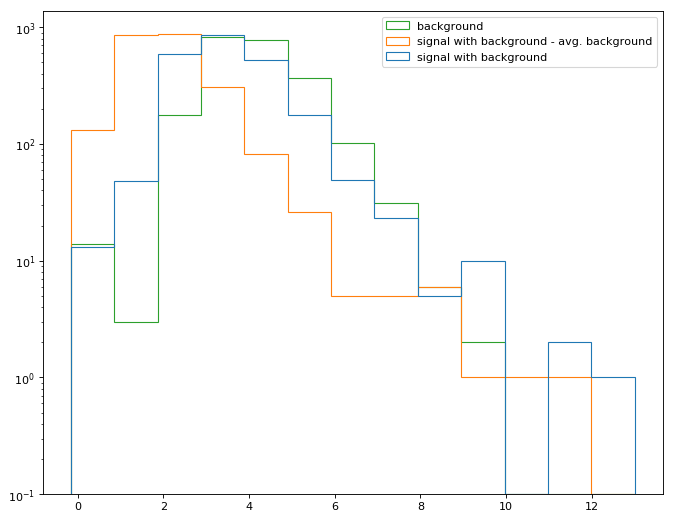

In [108]:
fig, ax = plt.subplots(1)
# ax.hist(xy_projections[n].flatten(), bins=13, log=True)
# fig, ax = plt.subplots(1)
# ax.hist((xy_projections[n] - avg_frames_background).flatten(), bins=12, log=True)
# fig, ax = plt.subplots(1)
# ax.hist(frames_background_xy_projections[n].flatten(), bins=9, log=True)
fig.set_size_inches(10,8)
ax.hist( np.transpose(np.vstack([xy_projections[n].flatten(), (xy_projections[n] - avg_frames_background).flatten() , 
                                 frames_background_xy_projections[n].flatten()
#                                  np.maximum.reduce(npy_clear_background).flatten()
                                ])), 
 13, stacked=False, histtype='step', # , histtype='bar',  #fill=False,
        log=True, label=['signal with background', 'signal with background - avg. background', 'background'])
ax.legend(prop={'size': 10})
plt.show()

In [319]:
threshold_minimum__num_invalid_to_count_nonzero_background__bgsub = np.zeros(len(xy_projections))
threshold_yen__num_invalid_to_count_nonzero_background__bgsub = np.zeros(len(xy_projections))
threshold_triangle__num_invalid_to_count_nonzero_background__bgsub = np.zeros(len(xy_projections))
threshold_isodata__num_invalid_to_count_nonzero_background__bgsub = np.zeros(len(xy_projections))
threshold_otsu__num_invalid_to_count_nonzero_background__bgsub = np.zeros(len(xy_projections))
threshold_li__num_invalid_to_count_nonzero_background__bgsub = np.zeros(len(xy_projections))

threshold_minimum__num_invalid_to_count_nonzero_background = np.zeros(len(xy_projections))
threshold_yen__num_invalid_to_count_nonzero_background = np.zeros(len(xy_projections))
threshold_triangle__num_invalid_to_count_nonzero_background = np.zeros(len(xy_projections))
threshold_isodata__num_invalid_to_count_nonzero_background = np.zeros(len(xy_projections))
threshold_otsu__num_invalid_to_count_nonzero_background = np.zeros(len(xy_projections))
threshold_li__num_invalid_to_count_nonzero_background = np.zeros(len(xy_projections))

gz = True
norm_out = False

for i, xy_proj in enumerate(xy_projections):
    # xy_proj
    xy_simu_proj = simu_xy_projections[i]
    xy_bg_proj = background_xy_projections[i]
    try:
        thr_img, thr_val = apply_threshold(xy_projections[i], skimage.filters.threshold_minimum, gz, norm_out)
        th_eff = thresholding_effciency(simu_xy_projections[i], xy_projections[i], thr_img)
        threshold_minimum__num_invalid_to_count_nonzero_background__bgsub[i] = th_eff[-1]
    except RuntimeError:
        pass
    try:
        thr_img, thr_val = apply_threshold(xy_projections[i] - avg_frames_background, skimage.filters.threshold_minimum, gz, norm_out)
        th_eff = thresholding_effciency(simu_xy_projections[i], xy_projections[i] - avg_frames_background, thr_img)
        threshold_minimum__num_invalid_to_count_nonzero_background__bgsub[i] = th_eff[-1]
    except RuntimeError:
        pass
        
    thr_img, thr_val = apply_threshold(xy_projections[i], skimage.filters.threshold_yen, gz, norm_out)
    th_eff = thresholding_effciency(simu_xy_projections[i], xy_projections[i], thr_img)
#     print(th_err)
    threshold_yen__num_invalid_to_count_nonzero_background__bgsub[i] = th_eff[-1]

    thr_img, thr_val = apply_threshold(xy_projections[i] - avg_frames_background, skimage.filters.threshold_yen, gz, norm_out)
    th_eff = thresholding_effciency(simu_xy_projections[i], xy_projections[i] - avg_frames_background, thr_img)
#     print(th_eff)
    threshold_yen__num_invalid_to_count_nonzero_background__bgsub[i] = th_eff[-1]

    
    thr_img, thr_val = apply_threshold(xy_projections[i], skimage.filters.threshold_triangle, gz, norm_out)
    th_eff = thresholding_effciency(simu_xy_projections[i], xy_projections[i], thr_img)
#     print(th_eff)
    threshold_triangle__num_invalid_to_count_nonzero_background__bgsub[i] = th_eff[-1]

    thr_img, thr_val = apply_threshold(xy_projections[i] - avg_frames_background, skimage.filters.threshold_triangle, gz, norm_out)
    th_eff = thresholding_effciency(simu_xy_projections[i], xy_projections[i] - avg_frames_background, thr_img)
    threshold_triangle__num_invalid_to_count_nonzero_background__bgsub[i] = th_eff[-1]
#     print(th_eff[-1], threshold_triangle__num_invalid_to_count_nonzero_background__bgsub[i])


    thr_img, thr_val = apply_threshold(xy_projections[i], skimage.filters.threshold_isodata, gz, norm_out)
    th_eff = thresholding_effciency(simu_xy_projections[i], xy_projections[i], thr_img)
    threshold_isodata__num_invalid_to_count_nonzero_background__bgsub[i] = th_eff[-1]

    thr_img, thr_val = apply_threshold(xy_projections[i] - avg_frames_background, skimage.filters.threshold_isodata, gz, norm_out)
    th_eff = thresholding_effciency(simu_xy_projections[i], xy_projections[i] - avg_frames_background, thr_img)
    threshold_isodata__num_invalid_to_count_nonzero_background__bgsub[i] = th_eff[-1]

    
    thr_img, thr_val = apply_threshold(xy_projections[i], skimage.filters.threshold_otsu, gz, norm_out)
    th_eff = thresholding_effciency(simu_xy_projections[i], xy_projections[i], thr_img)
    threshold_otsu__num_invalid_to_count_nonzero_background__bgsub[i] = th_eff[-1]

    thr_img, thr_val = apply_threshold(xy_projections[i] - avg_frames_background, skimage.filters.threshold_otsu, gz, norm_out)
    th_eff = thresholding_effciency(simu_xy_projections[i], xy_projections[i] - avg_frames_background, thr_img)
    threshold_otsu__num_invalid_to_count_nonzero_background__bgsub[i] = th_eff[-1]

    
    thr_img, thr_val = apply_threshold(xy_projections[i], skimage.filters.threshold_li, gz, norm_out)
    th_eff = thresholding_effciency(simu_xy_projections[i], xy_projections[i], thr_img)
    threshold_li__num_invalid_to_count_nonzero_background__bgsub[i] = th_eff[-1]

    thr_img, thr_val = apply_threshold(xy_projections[i] - avg_frames_background, skimage.filters.threshold_li, gz, norm_out)
    th_eff = thresholding_effciency(simu_xy_projections[i], xy_projections[i] - avg_frames_background, thr_img)
    threshold_li__num_invalid_to_count_nonzero_background__bgsub[i] = th_eff[-1]
    
#     print(threshold_yen__num_invalid_to_count_nonzero_background__bgsub[i])
#     print(threshold_otsu__num_invalid_to_count_nonzero_background__bgsub[i])
#     break

In [320]:
threshold_yen__num_invalid_to_count_nonzero_background__bgsub# == threshold_otsu__num_invalid_to_count_nonzero_background__bgsub

array([ 0.09004093,  0.06386861,  0.06624319, ...,  0.00234192,
        0.00190386,  0.00715308])

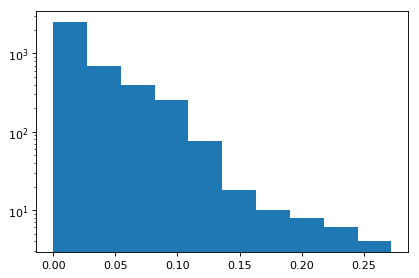

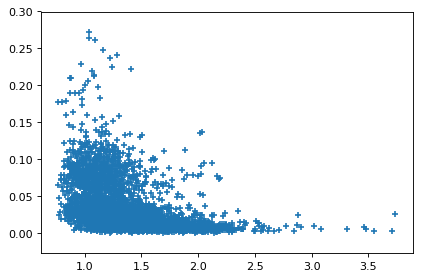

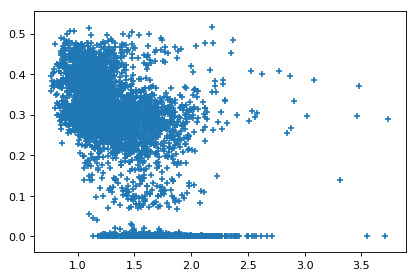

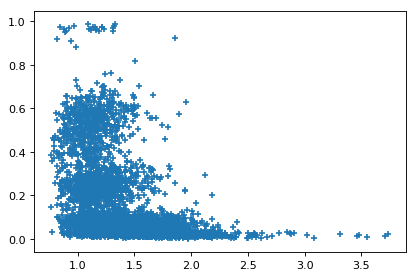

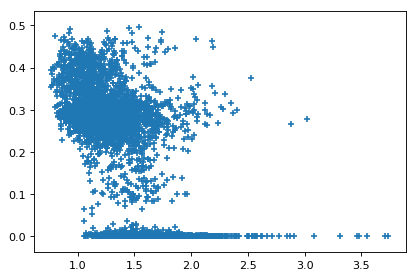

In [321]:
# plt.hist(signal_avg_to_bg_avg, log=True)
fig, ax = plt.subplots(1)
ax.hist(threshold_yen__num_invalid_to_count_nonzero_background__bgsub, log=True)
fig, ax = plt.subplots(1)
ax.scatter(signal_avg_to_bg_avg, threshold_yen__num_invalid_to_count_nonzero_background__bgsub, marker='+')
fig, ax = plt.subplots(1)
ax.scatter(signal_avg_to_bg_avg, threshold_isodata__num_invalid_to_count_nonzero_background__bgsub, marker='+')
fig, ax = plt.subplots(1)
ax.scatter(signal_avg_to_bg_avg, threshold_triangle__num_invalid_to_count_nonzero_background__bgsub, marker='+')
fig, ax = plt.subplots(1)
ax.scatter(signal_avg_to_bg_avg, threshold_otsu__num_invalid_to_count_nonzero_background__bgsub, marker='+')
plt.show()
# threshold_yen__num_invalid_to_count_nonzero_background__bgsub

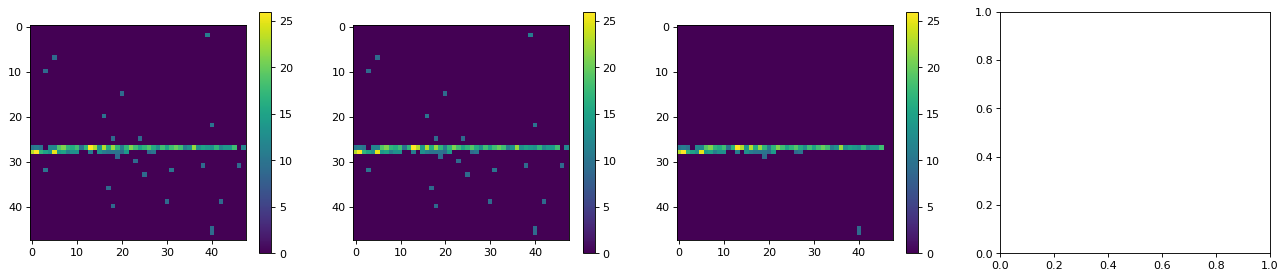

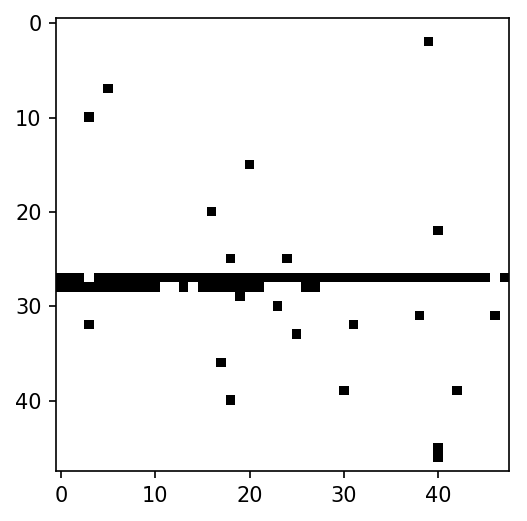

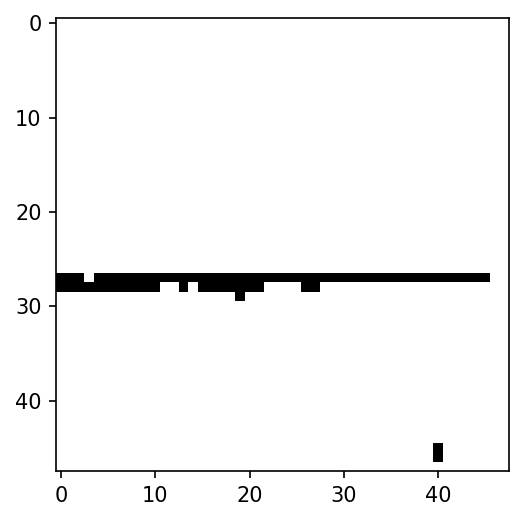

In [25]:
mpl.rcParams['figure.dpi'] = 80
fig, axs = plt.subplots(1,4)
fig.set_size_inches(20,4)
axs_flattened = axs.flatten()
bimg = threshold_yen(xy_projections[n]) > 0
i=0
cax = axs_flattened[i].imshow(xy_projections[n] * bimg)
fig.colorbar(cax, ax=axs_flattened[i])
i += 1
cax = axs_flattened[i].imshow(xy_projections[n] * removesaltim(bimg))
fig.colorbar(cax, ax=axs_flattened[i])
i += 1
cax = axs_flattened[i].imshow(xy_projections[n] * removepepperim(bimg))
fig.colorbar(cax, ax=axs_flattened[i])
i += 1

mpl.rcParams['figure.dpi'] = 150
fig, ax = plt.subplots(1)
ax.imshow(bimg, cmap='binary')

fig, ax = plt.subplots(1)
cax = ax.imshow(removepepperim(bimg), cmap='binary')

plt.show()

In [57]:
base_xy_proj_w_bg = xy_projections[n] * (xy_projections[n]>0)
base_xy_proj_w_bg_cent = (base_xy_proj_w_bg - base_xy_proj_w_bg.mean() )
base_xy_proj_w_bg_max_norm = base_xy_proj_w_bg_cent/np.max(np.abs(base_xy_proj_w_bg_cent))

print("base_xy_proj_w_bg.mean()",  base_xy_proj_w_bg.mean())
print('max(abs(base_xy_proj_w_bg_cent))', np.max(np.abs(base_xy_proj_w_bg_cent)))

base_xy_proj_n_bg = xy_projections[n] - avg_frames_background
base_xy_proj_n_bg *= (base_xy_proj_n_bg > 0)
base_xy_proj_n_bg_cent = (base_xy_proj_n_bg - base_xy_proj_n_bg.mean() )
base_xy_proj_n_bg_max_norm = base_xy_proj_n_bg_cent/np.max(np.abs(base_xy_proj_n_bg_cent))

print("base_xy_proj_n_bg.mean()",  base_xy_proj_n_bg.mean())
print('max(abs(base_xy_proj_n_bg_cent))', np.max(np.abs(base_xy_proj_n_bg_cent)))


base_xy_proj_w_bg.mean() 3.22135
max(abs(base_xy_proj_w_bg_cent)) 9.77865
base_xy_proj_n_bg.mean() 2.10579427083
max(abs(base_xy_proj_n_bg_cent)) 9.86295572917


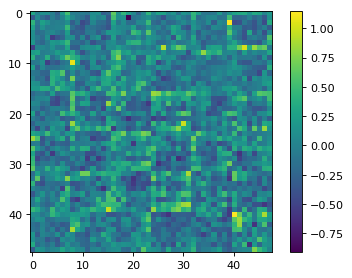

In [58]:
mpl.rcParams['figure.dpi'] = 80
np.max(base_xy_proj - base_xy_proj_n_bg)
cax = plt.imshow(base_xy_proj - base_xy_proj_n_bg) # avg_frames_background
plt.colorbar(cax)
plt.show()

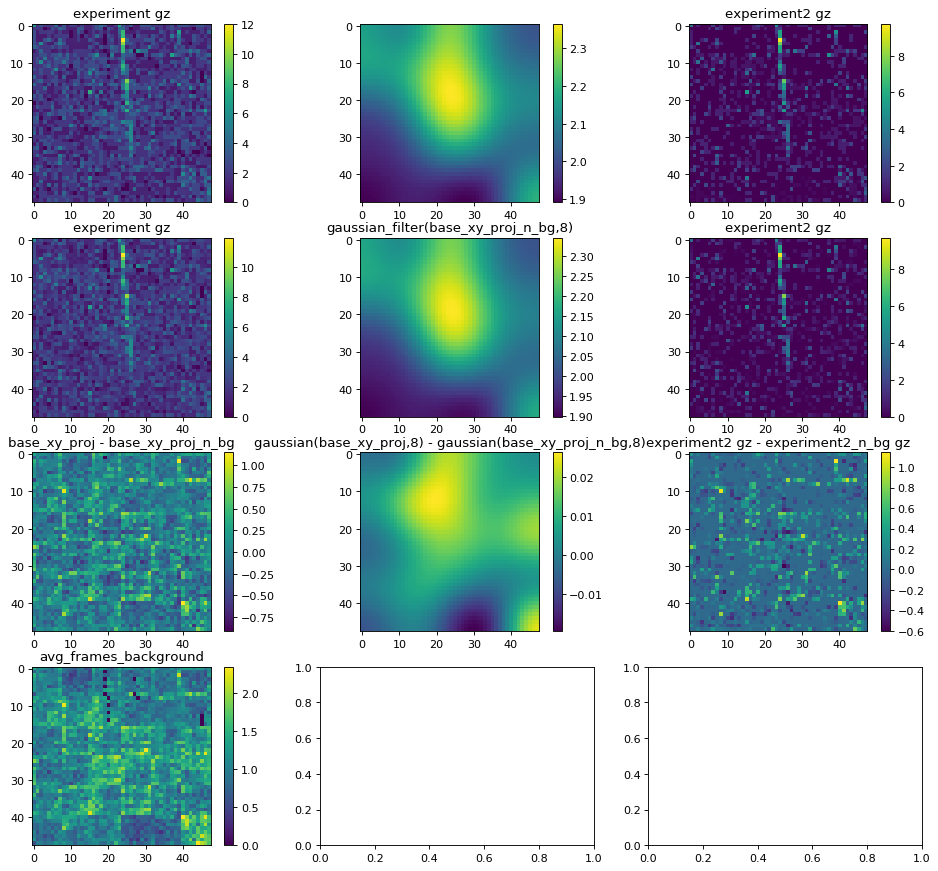

In [59]:
mpl.rcParams['figure.dpi'] = 80

cols=3
rows=4

plt.close('all')
fig, axs = plt.subplots(rows,cols)
fig.set_size_inches(cols*5,rows*4*0.85)
axs_flattened = axs.flatten()
i=0
# cax = axs_flattened[i].imshow(base_xy_proj_w_bg)
# fig.colorbar(cax, ax=axs_flattened[i])
# i += 1
# cax = axs_flattened[i].imshow(base_xy_proj_n_bg)
# fig.colorbar(cax, ax=axs_flattened[i])
# i += 1
# cax = axs_flattened[i].imshow( skimage.filters.median(base_xy_proj_w_bg_max_norm, np.ones((3,3))) )
# axs_flattened[i].set_title('skimage.filters.median w_bg')
# fig.colorbar(cax, ax=axs_flattened[i])
# i += 1
# cax = axs_flattened[i].imshow( skimage.filters.median(base_xy_proj_n_bg_max_norm, np.ones((3,3))) )
# axs_flattened[i].set_title('skimage.filters.median n_bg')
# fig.colorbar(cax, ax=axs_flattened[i])
# i += 1

experiment = base_xy_proj - scipy.ndimage.filters.gaussian_filter(base_xy_proj,2) #
experiment2 = base_xy_proj - scipy.ndimage.filters.gaussian_filter(base_xy_proj,8) #
experiment2_n_bg = base_xy_proj_n_bg - scipy.ndimage.filters.gaussian_filter(base_xy_proj_n_bg,8) #

experiment3 = scipy.ndimage.filters.gaussian_filter(base_xy_proj,1) - scipy.ndimage.filters.gaussian_filter(base_xy_proj,3)

experiment4 = xy_projections[n] - scipy.ndimage.filters.gaussian_filter(xy_projections[n],3) # skimage.filters.gaussian_filter(xy_projections[n],1)
experiment5 = base_xy_proj_max_norm - skimage.filters.gaussian(base_xy_proj_max_norm,3)

# cax = axs_flattened[i].imshow(  (base_xy_proj) * (base_xy_proj>0)  , interpolation='none') #  * (xy_projections_bgsub[n]>0)   #  *np.ones_like(xy_projections_bgsub[n])*50 )
# axs_flattened[i].set_title('base_xy_proj gz')
# fig.colorbar(cax, ax=axs_flattened[i])
# i += 1
cax = axs_flattened[i].imshow(  base_xy_proj , interpolation='none') # (experiment) * (experiment>0) # * (xy_projections_bgsub[n]>0)   #  *np.ones_like(xy_projections_bgsub[n])*50 )
axs_flattened[i].set_title('experiment gz')
fig.colorbar(cax, ax=axs_flattened[i])
i += 1
cax = axs_flattened[i].imshow(  scipy.ndimage.filters.gaussian_filter(base_xy_proj,8)  , interpolation='none') # (experiment) * (experiment>0) # * (xy_projections_bgsub[n]>0)   #  *np.ones_like(xy_projections_bgsub[n])*50 )
axs_flattened[i].set_title('')
fig.colorbar(cax, ax=axs_flattened[i])
i += 1
cax = axs_flattened[i].imshow(  (experiment2) * (experiment2>0)  , interpolation='none') #  * (xy_projections_bgsub[n]>0)   #  *np.ones_like(xy_projections_bgsub[n])*50 )
axs_flattened[i].set_title('experiment2 gz')
fig.colorbar(cax, ax=axs_flattened[i])
i += 1

cax = axs_flattened[i].imshow(  base_xy_proj_n_bg , interpolation='none') # (experiment) * (experiment>0) # * (xy_projections_bgsub[n]>0)   #  *np.ones_like(xy_projections_bgsub[n])*50 )
axs_flattened[i].set_title('experiment gz')
fig.colorbar(cax, ax=axs_flattened[i])
i += 1
cax = axs_flattened[i].imshow(  scipy.ndimage.filters.gaussian_filter(base_xy_proj_n_bg,8)  , interpolation='none') # (experiment) * (experiment>0) # * (xy_projections_bgsub[n]>0)   #  *np.ones_like(xy_projections_bgsub[n])*50 )
axs_flattened[i].set_title('gaussian_filter(base_xy_proj_n_bg,8)')
fig.colorbar(cax, ax=axs_flattened[i])
i += 1
cax = axs_flattened[i].imshow(  (experiment2_n_bg) * (experiment2_n_bg>0)  , interpolation='none') #  * (xy_projections_bgsub[n]>0)   #  *np.ones_like(xy_projections_bgsub[n])*50 )
axs_flattened[i].set_title('experiment2 gz')
fig.colorbar(cax, ax=axs_flattened[i])
i += 1

cax = axs_flattened[i].imshow(  base_xy_proj - base_xy_proj_n_bg  , interpolation='none') #  * (xy_projections_bgsub[n]>0)   #  *np.ones_like(xy_projections_bgsub[n])*50 )
axs_flattened[i].set_title('base_xy_proj - base_xy_proj_n_bg')
fig.colorbar(cax, ax=axs_flattened[i])
i += 1
cax = axs_flattened[i].imshow( scipy.ndimage.filters.gaussian_filter(base_xy_proj,8) - scipy.ndimage.filters.gaussian_filter(base_xy_proj_n_bg,8)  , interpolation='none') # (experiment) * (experiment>0) # * (xy_projections_bgsub[n]>0)   #  *np.ones_like(xy_projections_bgsub[n])*50 )
axs_flattened[i].set_title('gaussian(base_xy_proj,8) - gaussian(base_xy_proj_n_bg,8)')
fig.colorbar(cax, ax=axs_flattened[i])
i += 1
cax = axs_flattened[i].imshow( (experiment2) * (experiment2>0) - (experiment2_n_bg) * (experiment2_n_bg>0)  , interpolation='none') #  * (xy_projections_bgsub[n]>0)   #  *np.ones_like(xy_projections_bgsub[n])*50 )
axs_flattened[i].set_title('experiment2 gz - experiment2_n_bg gz')
fig.colorbar(cax, ax=axs_flattened[i])
i += 1                              
                              
cax = axs_flattened[i].imshow(  avg_frames_background , interpolation='none') # (experiment) * (experiment>0) # * (xy_projections_bgsub[n]>0)   #  *np.ones_like(xy_projections_bgsub[n])*50 )
axs_flattened[i].set_title('avg_frames_background')
fig.colorbar(cax, ax=axs_flattened[i])
i += 1

plt.show()

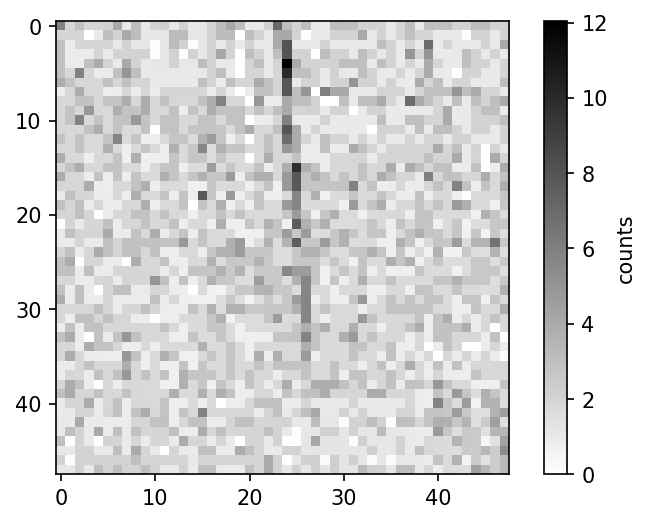

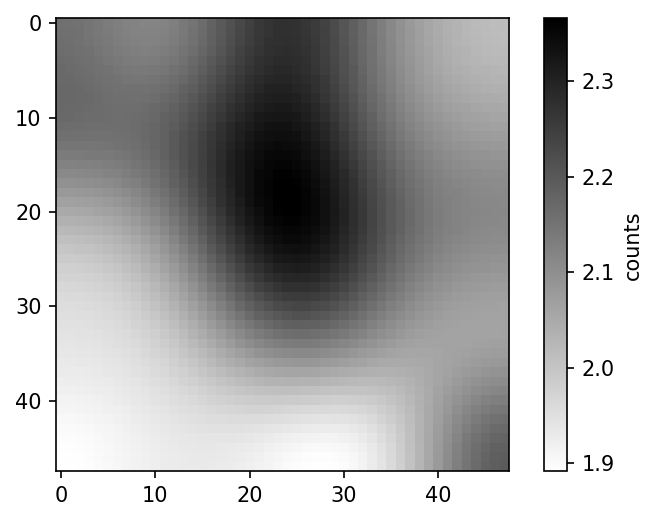

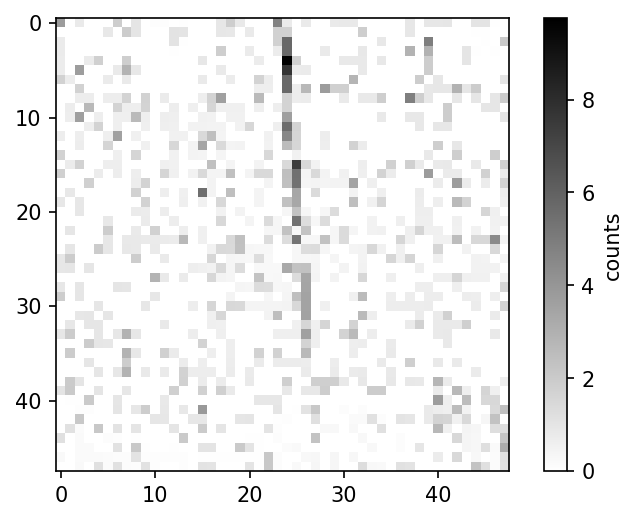

In [60]:
mpl.rcParams['figure.dpi'] = 150

cols=1
rows=1

plt.close('all')
# fig, axs = plt.subplots(rows,cols)
fig, ax = plt.subplots(1)
# fig.set_size_inches(cols*5,rows*4*0.85)
# axs_flattened = axs.flatten()
i=0
# cax = axs_flattened[i].imshow(base_xy_proj_w_bg)
# fig.colorbar(cax, ax=axs_flattened[i])
# i += 1
# cax = axs_flattened[i].imshow(base_xy_proj_n_bg)
# fig.colorbar(cax, ax=axs_flattened[i])
# i += 1
# cax = axs_flattened[i].imshow( skimage.filters.median(base_xy_proj_w_bg_max_norm, np.ones((3,3))) )
# axs_flattened[i].set_title('skimage.filters.median w_bg')
# fig.colorbar(cax, ax=axs_flattened[i])
# i += 1
# cax = axs_flattened[i].imshow( skimage.filters.median(base_xy_proj_n_bg_max_norm, np.ones((3,3))) )
# axs_flattened[i].set_title('skimage.filters.median n_bg')
# fig.colorbar(cax, ax=axs_flattened[i])
# i += 1

experiment = base_xy_proj - scipy.ndimage.filters.gaussian_filter(base_xy_proj,2) #
experiment2 = base_xy_proj - scipy.ndimage.filters.gaussian_filter(base_xy_proj,8) #
experiment2_n_bg = base_xy_proj_n_bg - scipy.ndimage.filters.gaussian_filter(base_xy_proj_n_bg,8) #

experiment3 = scipy.ndimage.filters.gaussian_filter(base_xy_proj,1) - scipy.ndimage.filters.gaussian_filter(base_xy_proj,3)

experiment4 = xy_projections[n] - scipy.ndimage.filters.gaussian_filter(xy_projections[n],3) # skimage.filters.gaussian_filter(xy_projections[n],1)
experiment5 = base_xy_proj_max_norm - skimage.filters.gaussian(base_xy_proj_max_norm,3)

# cax = axs_flattened[i].imshow(  (base_xy_proj) * (base_xy_proj>0)  , interpolation='none') #  * (xy_projections_bgsub[n]>0)   #  *np.ones_like(xy_projections_bgsub[n])*50 )
# axs_flattened[i].set_title('base_xy_proj gz')
# fig.colorbar(cax, ax=axs_flattened[i])
# i += 1
cax = ax.imshow(  base_xy_proj , interpolation='none', cmap='binary') # (experiment) * (experiment>0) # * (xy_projections_bgsub[n]>0)   #  *np.ones_like(xy_projections_bgsub[n])*50 )
# ax.set_title('experiment gz')
fig.colorbar(cax, ax=ax, label='counts')
# i += 1
fig, ax = plt.subplots(1)
cax = ax.imshow(  scipy.ndimage.filters.gaussian_filter(base_xy_proj,8)  , interpolation='none', cmap='binary') # (experiment) * (experiment>0) # * (xy_projections_bgsub[n]>0)   #  *np.ones_like(xy_projections_bgsub[n])*50 )
# ax.set_title('gaussian_filter(base_xy_proj,8)')
fig.colorbar(cax, ax=ax, label='counts')
# i += 1
fig, ax = plt.subplots(1)
cax = ax.imshow(  (experiment2) * (experiment2>0)  , interpolation='none', cmap='binary') #  * (xy_projections_bgsub[n]>0)   #  *np.ones_like(xy_projections_bgsub[n])*50 )
# ax.set_title('experiment2 gz')
fig.colorbar(cax, ax=ax, label='counts')
# i += 1
plt.show()

/home/eusobg/EUSO-SPB/euso-spb-patt-reco-v1/venv/lib/python3.5/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float32 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/home/eusobg/EUSO-SPB/euso-spb-patt-reco-v1/venv/lib/python3.5/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


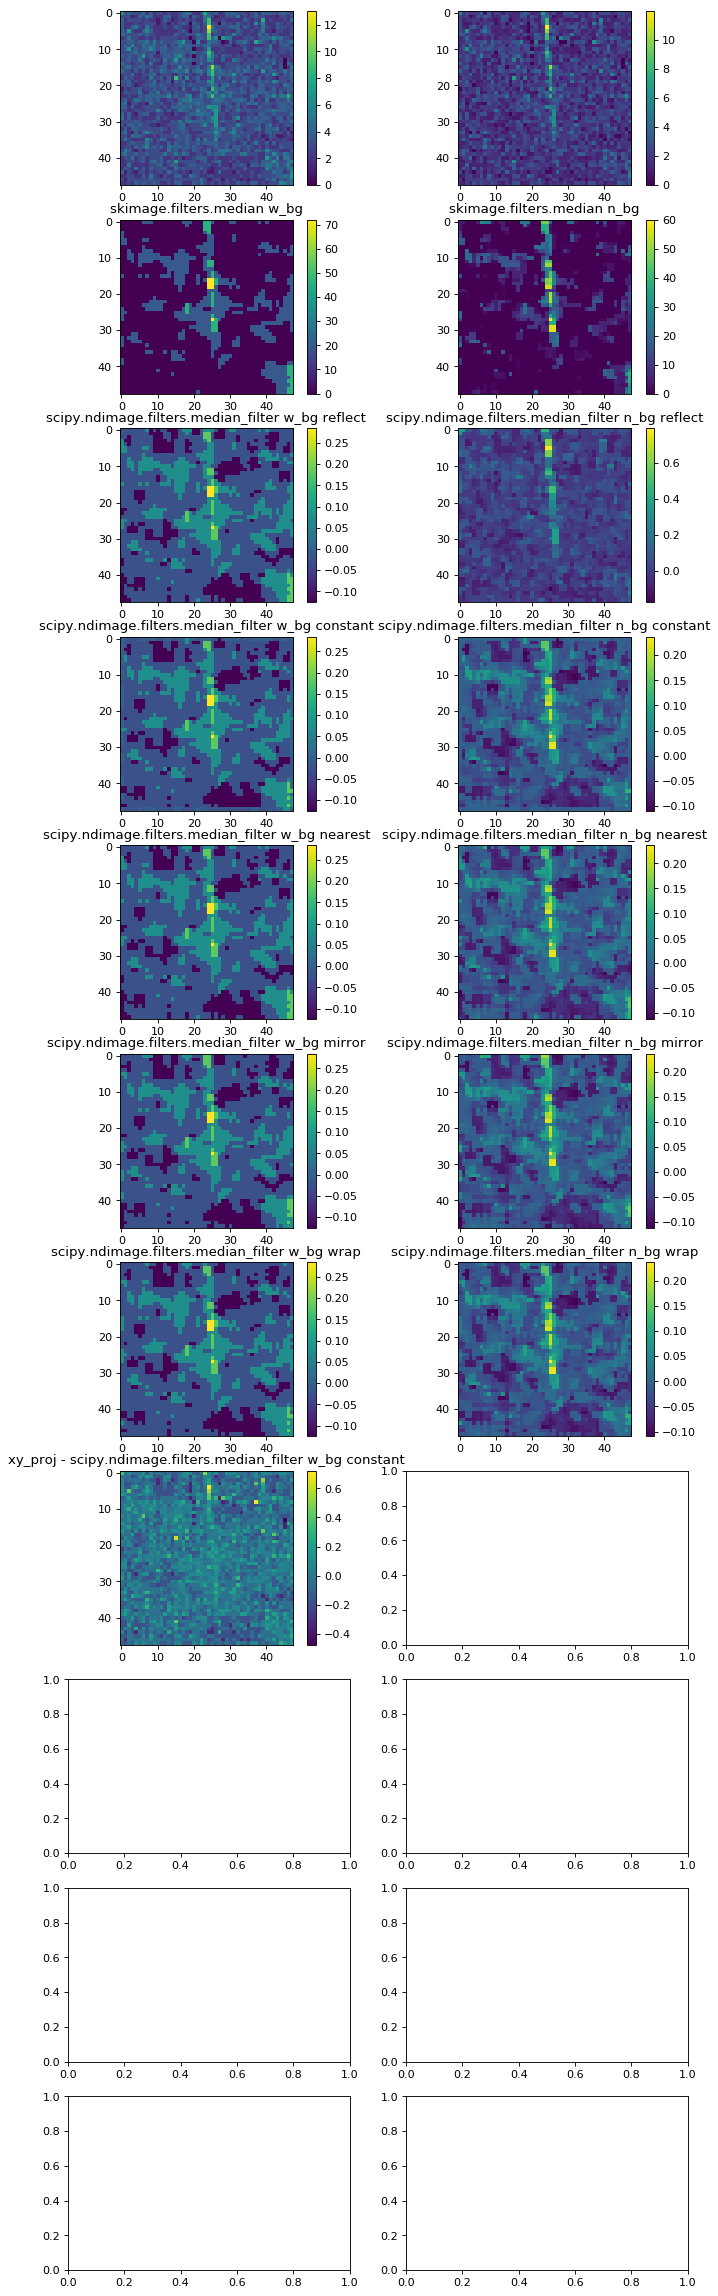

In [61]:

mpl.rcParams['figure.dpi'] = 80

cols=2
rows=11

plt.close('all')
fig, axs = plt.subplots(rows,cols)
fig.set_size_inches(cols*5,rows*4*0.85)
axs_flattened = axs.flatten()
i=0
cax = axs_flattened[i].imshow(base_xy_proj_w_bg)
fig.colorbar(cax, ax=axs_flattened[i])
i += 1
cax = axs_flattened[i].imshow(base_xy_proj_n_bg)
fig.colorbar(cax, ax=axs_flattened[i])
i += 1
cax = axs_flattened[i].imshow( skimage.filters.median(base_xy_proj_w_bg_max_norm, np.ones((3,3))) )
axs_flattened[i].set_title('skimage.filters.median w_bg')
fig.colorbar(cax, ax=axs_flattened[i])
i += 1
cax = axs_flattened[i].imshow( skimage.filters.median(base_xy_proj_n_bg_max_norm, np.ones((3,3))) )
axs_flattened[i].set_title('skimage.filters.median n_bg')
fig.colorbar(cax, ax=axs_flattened[i])
i += 1

cax = axs_flattened[i].imshow( scipy.ndimage.filters.median_filter(base_xy_proj_w_bg_max_norm, footprint=np.ones((3,3)) , mode='reflect' )
#                              * (scipy.ndimage.filters.median_filter(base_xy_proj_w_bg_max_norm, footprint=np.ones((3,3)) , mode='reflect' ) > 0)
                             )
axs_flattened[i].set_title('scipy.ndimage.filters.median_filter w_bg reflect')
fig.colorbar(cax, ax=axs_flattened[i])
i += 1
cax = axs_flattened[i].imshow( scipy.ndimage.filters.median_filter(base_xy_proj_n_bg_max_norm, footprint=np.ones((2,2)), mode='reflect' ) )
axs_flattened[i].set_title('scipy.ndimage.filters.median_filter n_bg reflect')
fig.colorbar(cax, ax=axs_flattened[i])
i += 1
cax = axs_flattened[i].imshow( scipy.ndimage.filters.median_filter(base_xy_proj_w_bg_max_norm, footprint=np.ones((3,3)), mode='constant' ) )
axs_flattened[i].set_title('scipy.ndimage.filters.median_filter w_bg constant')
fig.colorbar(cax, ax=axs_flattened[i])
i += 1
cax = axs_flattened[i].imshow( scipy.ndimage.filters.median_filter(base_xy_proj_n_bg_max_norm, footprint=np.ones((3,3)), mode='constant' ) )
axs_flattened[i].set_title('scipy.ndimage.filters.median_filter n_bg constant')
fig.colorbar(cax, ax=axs_flattened[i])
i += 1
cax = axs_flattened[i].imshow( scipy.ndimage.filters.median_filter(base_xy_proj_w_bg_max_norm, footprint=np.ones((3,3)), mode='nearest' ) )
axs_flattened[i].set_title('scipy.ndimage.filters.median_filter w_bg nearest')
fig.colorbar(cax, ax=axs_flattened[i])
i += 1
cax = axs_flattened[i].imshow( scipy.ndimage.filters.median_filter(base_xy_proj_n_bg_max_norm, footprint=np.ones((3,3)), mode='nearest' ) )
axs_flattened[i].set_title('scipy.ndimage.filters.median_filter n_bg nearest')
fig.colorbar(cax, ax=axs_flattened[i])
i += 1
cax = axs_flattened[i].imshow( scipy.ndimage.filters.median_filter(base_xy_proj_w_bg_max_norm, footprint=np.ones((3,3)), mode='mirror' ) )
axs_flattened[i].set_title('scipy.ndimage.filters.median_filter w_bg mirror')
fig.colorbar(cax, ax=axs_flattened[i])
i += 1
cax = axs_flattened[i].imshow( scipy.ndimage.filters.median_filter(base_xy_proj_n_bg_max_norm, footprint=np.ones((3,3)), mode='mirror' ) )
axs_flattened[i].set_title('scipy.ndimage.filters.median_filter n_bg mirror')
fig.colorbar(cax, ax=axs_flattened[i])
i += 1
cax = axs_flattened[i].imshow( scipy.ndimage.filters.median_filter(base_xy_proj_w_bg_max_norm, footprint=np.ones((3,3)), mode='wrap' ) )
axs_flattened[i].set_title('scipy.ndimage.filters.median_filter w_bg wrap')
fig.colorbar(cax, ax=axs_flattened[i])
i += 1
cax = axs_flattened[i].imshow( scipy.ndimage.filters.median_filter(base_xy_proj_n_bg_max_norm, footprint=np.ones((3,3)), mode='wrap' ) )
axs_flattened[i].set_title('scipy.ndimage.filters.median_filter n_bg wrap')
fig.colorbar(cax, ax=axs_flattened[i])
i += 1

median_norm = scipy.ndimage.filters.median_filter(base_xy_proj_w_bg_max_norm, footprint=np.ones((3,3)) , mode='constant' )
median_norm /= np.max(median_norm)
                                                  
cax = axs_flattened[i].imshow( base_xy_proj_w_bg_max_norm - base_xy_proj_w_bg_max_norm*median_norm )
axs_flattened[i].set_title('xy_proj - scipy.ndimage.filters.median_filter w_bg constant')
fig.colorbar(cax, ax=axs_flattened[i])
i += 1
# cax = axs_flattened[i].imshow( scipy.ndimage.filters.median_filter(base_xy_proj_n_bg_max_norm, footprint=np.ones((3,3)), mode='constant' ) )
# axs_flattened[i].set_title('scipy.ndimage.filters.median_filter n_bg constant')
# fig.colorbar(cax, ax=axs_flattened[i])
# i += 1

plt.show()

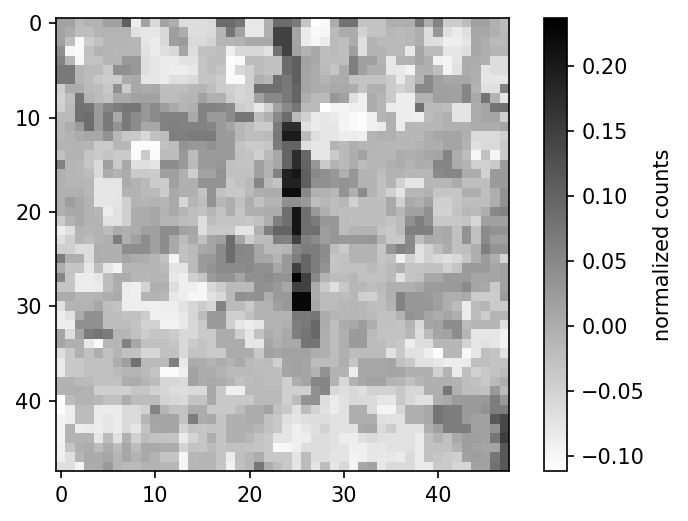

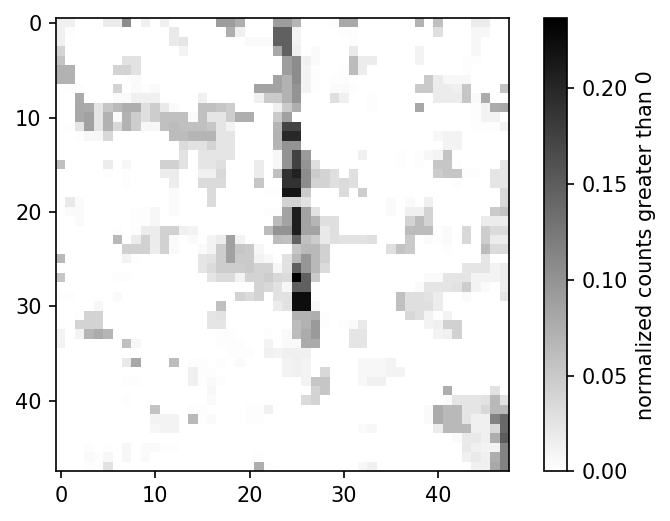

In [62]:
mpl.rcParams['figure.dpi'] = 150

base_xy_proj_n_bg_max_norm_median = scipy.ndimage.filters.median_filter(base_xy_proj_n_bg_max_norm, footprint=np.ones((3,3)), mode='reflect')

plt.close('all')
fig, ax = plt.subplots(1)
cax = plt.imshow(base_xy_proj_n_bg_max_norm_median, cmap='binary')
plt.colorbar(cax, label="normalized counts")
fig, ax = plt.subplots(1)
cax = plt.imshow(base_xy_proj_n_bg_max_norm_median * (base_xy_proj_n_bg_max_norm_median > 0), cmap='binary')
plt.colorbar(cax, label="normalized counts greater than 0")
plt.show()
plt.show()

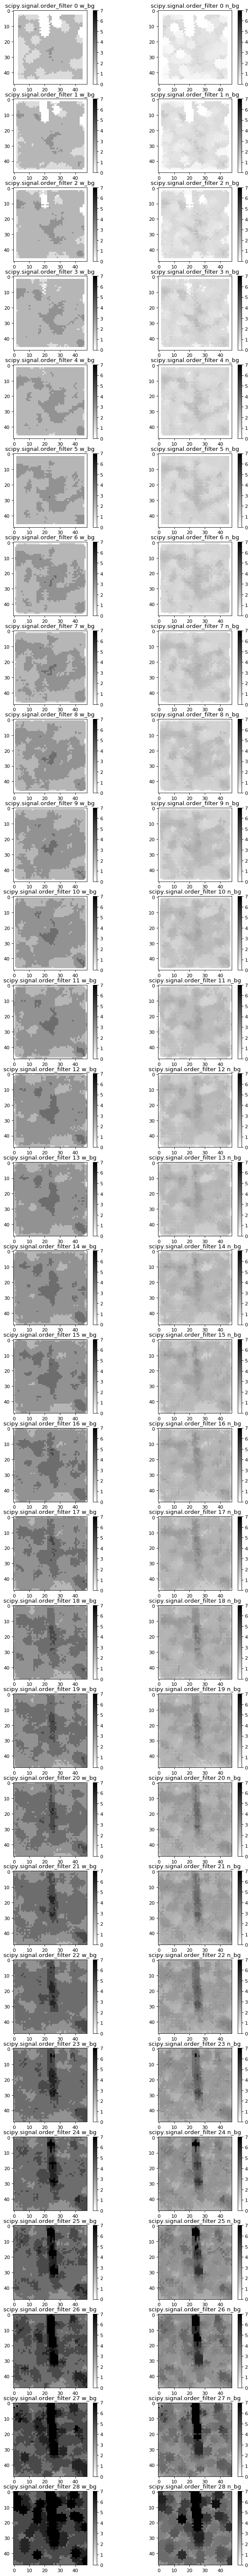

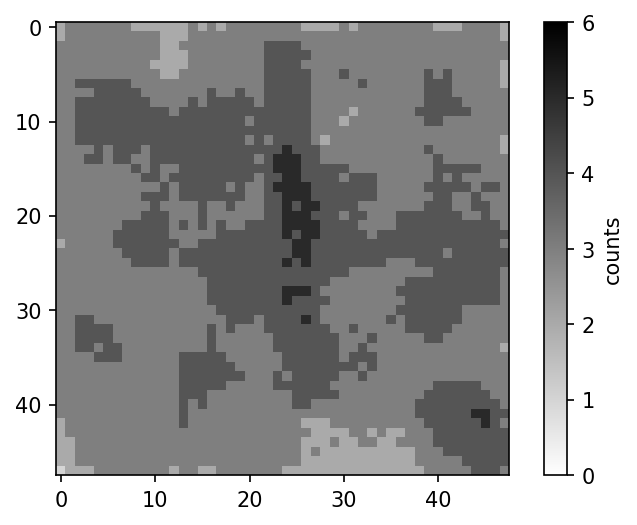

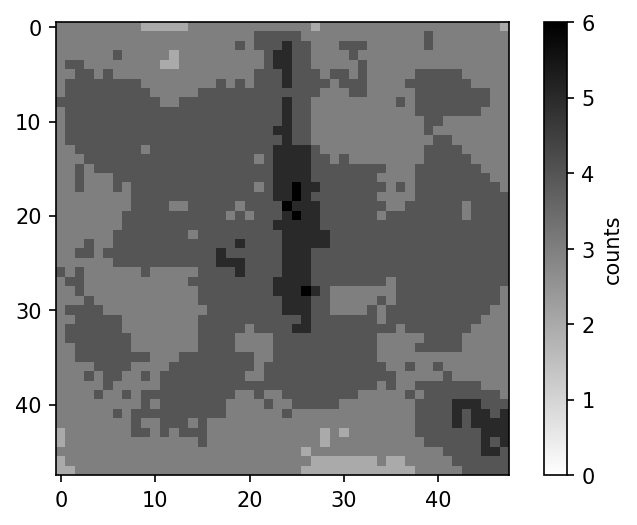

In [63]:
plt.close('all')
mpl.rcParams['figure.dpi'] = 80
order_filter_morphhology = skimage.morphology.disk(3)
cols=2
rows=np.count_nonzero(order_filter_morphhology)


fig, axs = plt.subplots(rows,cols)
fig.set_size_inches(cols*5,rows*4*0.85)
axs_flattened = axs.flatten()
i=0
for j in range (0,np.count_nonzero(order_filter_morphhology)):
    cax = axs_flattened[i].imshow( scipy.signal.order_filter(base_xy_proj_w_bg, order_filter_morphhology, j) , cmap='binary', vmin=0, vmax=7)   # np.ones((3,3))
    axs_flattened[i].set_title('scipy.signal.order_filter {:d} w_bg'.format(j))
    fig.colorbar(cax, ax=axs_flattened[i])
    i += 1
    cax = axs_flattened[i].imshow( scipy.signal.order_filter(base_xy_proj_n_bg, order_filter_morphhology, j) , cmap='binary', vmin=0, vmax=7 )   # np.ones((3,3))
    axs_flattened[i].set_title('scipy.signal.order_filter {:d} n_bg'.format(j))
    fig.colorbar(cax, ax=axs_flattened[i])
    i += 1
    
mpl.rcParams['figure.dpi'] = 150

fig, ax = plt.subplots(1)
cax = ax.imshow(  scipy.signal.order_filter(base_xy_proj_w_bg, order_filter_morphhology, 18), cmap='binary', vmin=0, vmax=6)
fig.colorbar(cax, label="counts", ax=ax)

fig, ax = plt.subplots(1)
cax = ax.imshow(  scipy.signal.order_filter(base_xy_proj_w_bg, order_filter_morphhology, 20), cmap='binary', vmin=0, vmax=6)
fig.colorbar(cax, label="counts", ax=ax)  

plt.show()

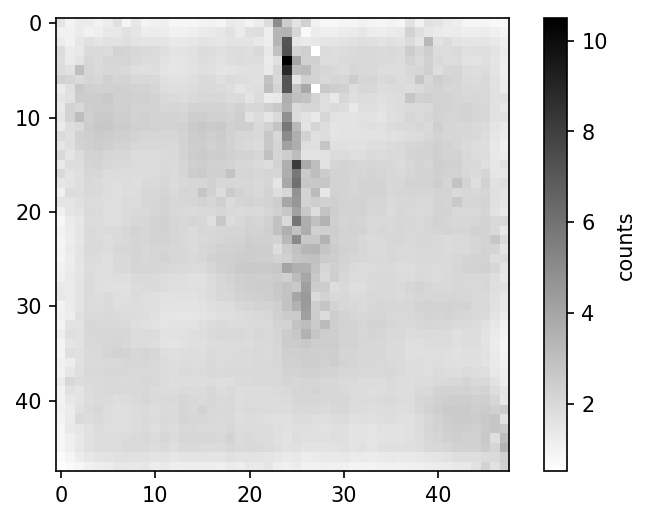

In [64]:
plt.close('all')
mpl.rcParams['figure.dpi'] = 80
# order_filter_morphhology = skimage.morphology.disk(3)
# cols=2
# rows=np.count_nonzero(order_filter_morphhology)


# fig, axs = plt.subplots(rows,cols)
# fig.set_size_inches(cols*5,rows*4*0.85)
# axs_flattened = axs.flatten()
# i=0
# for j in range (0,np.count_nonzero(order_filter_morphhology)):
#     cax = axs_flattened[i].imshow( scipy.signal.order_filter(base_xy_proj_w_bg, order_filter_morphhology, j) , cmap='binary', vmin=0, vmax=7)   # np.ones((3,3))
#     axs_flattened[i].set_title('scipy.signal.order_filter {:d} w_bg'.format(j))
#     fig.colorbar(cax, ax=axs_flattened[i])
#     i += 1
#     cax = axs_flattened[i].imshow( scipy.signal.order_filter(base_xy_proj_n_bg, order_filter_morphhology, j) , cmap='binary', vmin=0, vmax=7 )   # np.ones((3,3))
#     axs_flattened[i].set_title('scipy.signal.order_filter {:d} n_bg'.format(j))
#     fig.colorbar(cax, ax=axs_flattened[i])
#     i += 1
    
mpl.rcParams['figure.dpi'] = 150

# fig, ax = plt.subplots(1)
# cax = ax.imshow(  scipy.signal.order_filter(base_xy_proj_w_bg, order_filter_morphhology, 18), cmap='binary', vmin=0, vmax=6)
# fig.colorbar(cax, label="counts", ax=ax)

fig, ax = plt.subplots(1)
cax = ax.imshow(  scipy.signal.wiener(base_xy_proj_n_bg, mysize=6, noise=None) , cmap='binary',) #
fig.colorbar(cax, label="counts", ax=ax)  

plt.show()

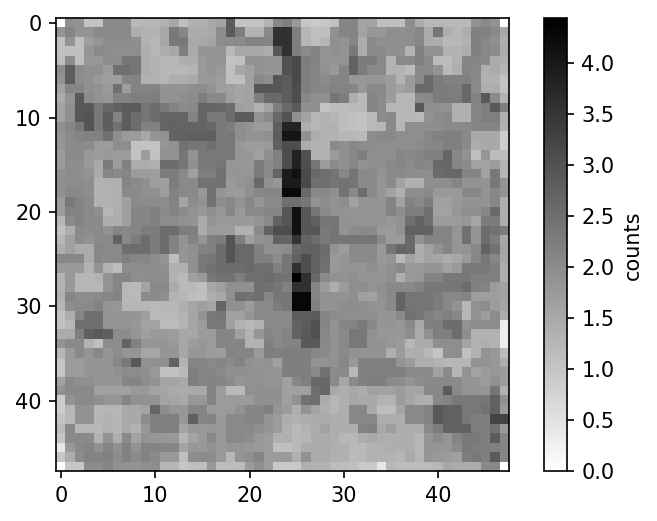

In [65]:
plt.close('all')
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['figure.dpi'] = 150

# fig, ax = plt.subplots(1)
# cax = ax.imshow(  scipy.signal.order_filter(base_xy_proj_w_bg, order_filter_morphhology, 18), cmap='binary', vmin=0, vmax=6)
# fig.colorbar(cax, label="counts", ax=ax)

fig, ax = plt.subplots(1)
cax = ax.imshow(  scipy.signal.medfilt(base_xy_proj_n_bg,) , cmap='binary',) #
fig.colorbar(cax, label="counts", ax=ax)  

plt.show()

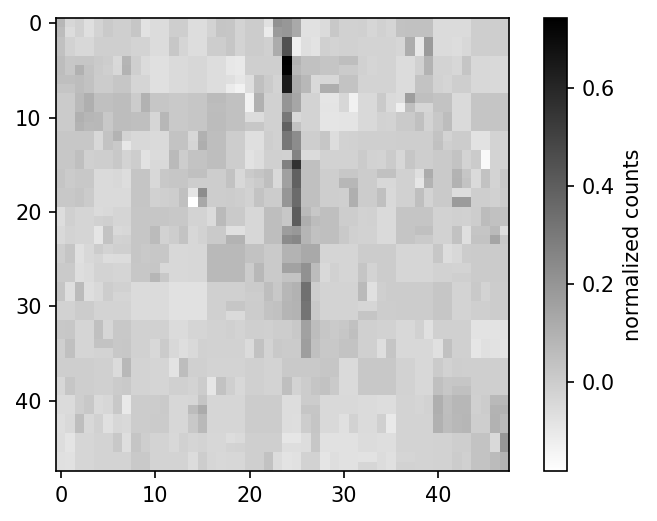

In [66]:
plt.close('all')
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['figure.dpi'] = 150

# fig, ax = plt.subplots(1)
# cax = ax.imshow(  scipy.signal.order_filter(base_xy_proj_w_bg, order_filter_morphhology, 18), cmap='binary', vmin=0, vmax=6)
# fig.colorbar(cax, label="counts", ax=ax)

fig, ax = plt.subplots(1)
cax = ax.imshow(  skimage.restoration.denoise_wavelet(base_xy_proj_n_bg_max_norm, sigma=None, multichannel=False) , cmap='binary',) #
fig.colorbar(cax, label="normalized counts", ax=ax)  

plt.show()


# cax = axs_flattened[i].imshow( skimage.restoration.denoise_wavelet(base_xy_proj_w_bg_max_norm, multichannel=False) ) 
# axs_flattened[i].set_title('skimage.restoration.denoise_wavelet w_bg')
# fig.colorbar(cax, ax=axs_flattened[i])
# i += 1
# cax = axs_flattened[i].imshow( skimage.restoration.denoise_wavelet(base_xy_proj_n_bg_max_norm, multichannel=False) )
# axs_flattened[i].set_title('skimage.restoration.denoise_wavelet n_bg')
# fig.colorbar(cax, ax=axs_flattened[i])
# i += 1

/home/eusobg/EUSO-SPB/euso-spb-patt-reco-v1/venv/lib/python3.5/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float32 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/home/eusobg/EUSO-SPB/euso-spb-patt-reco-v1/venv/lib/python3.5/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


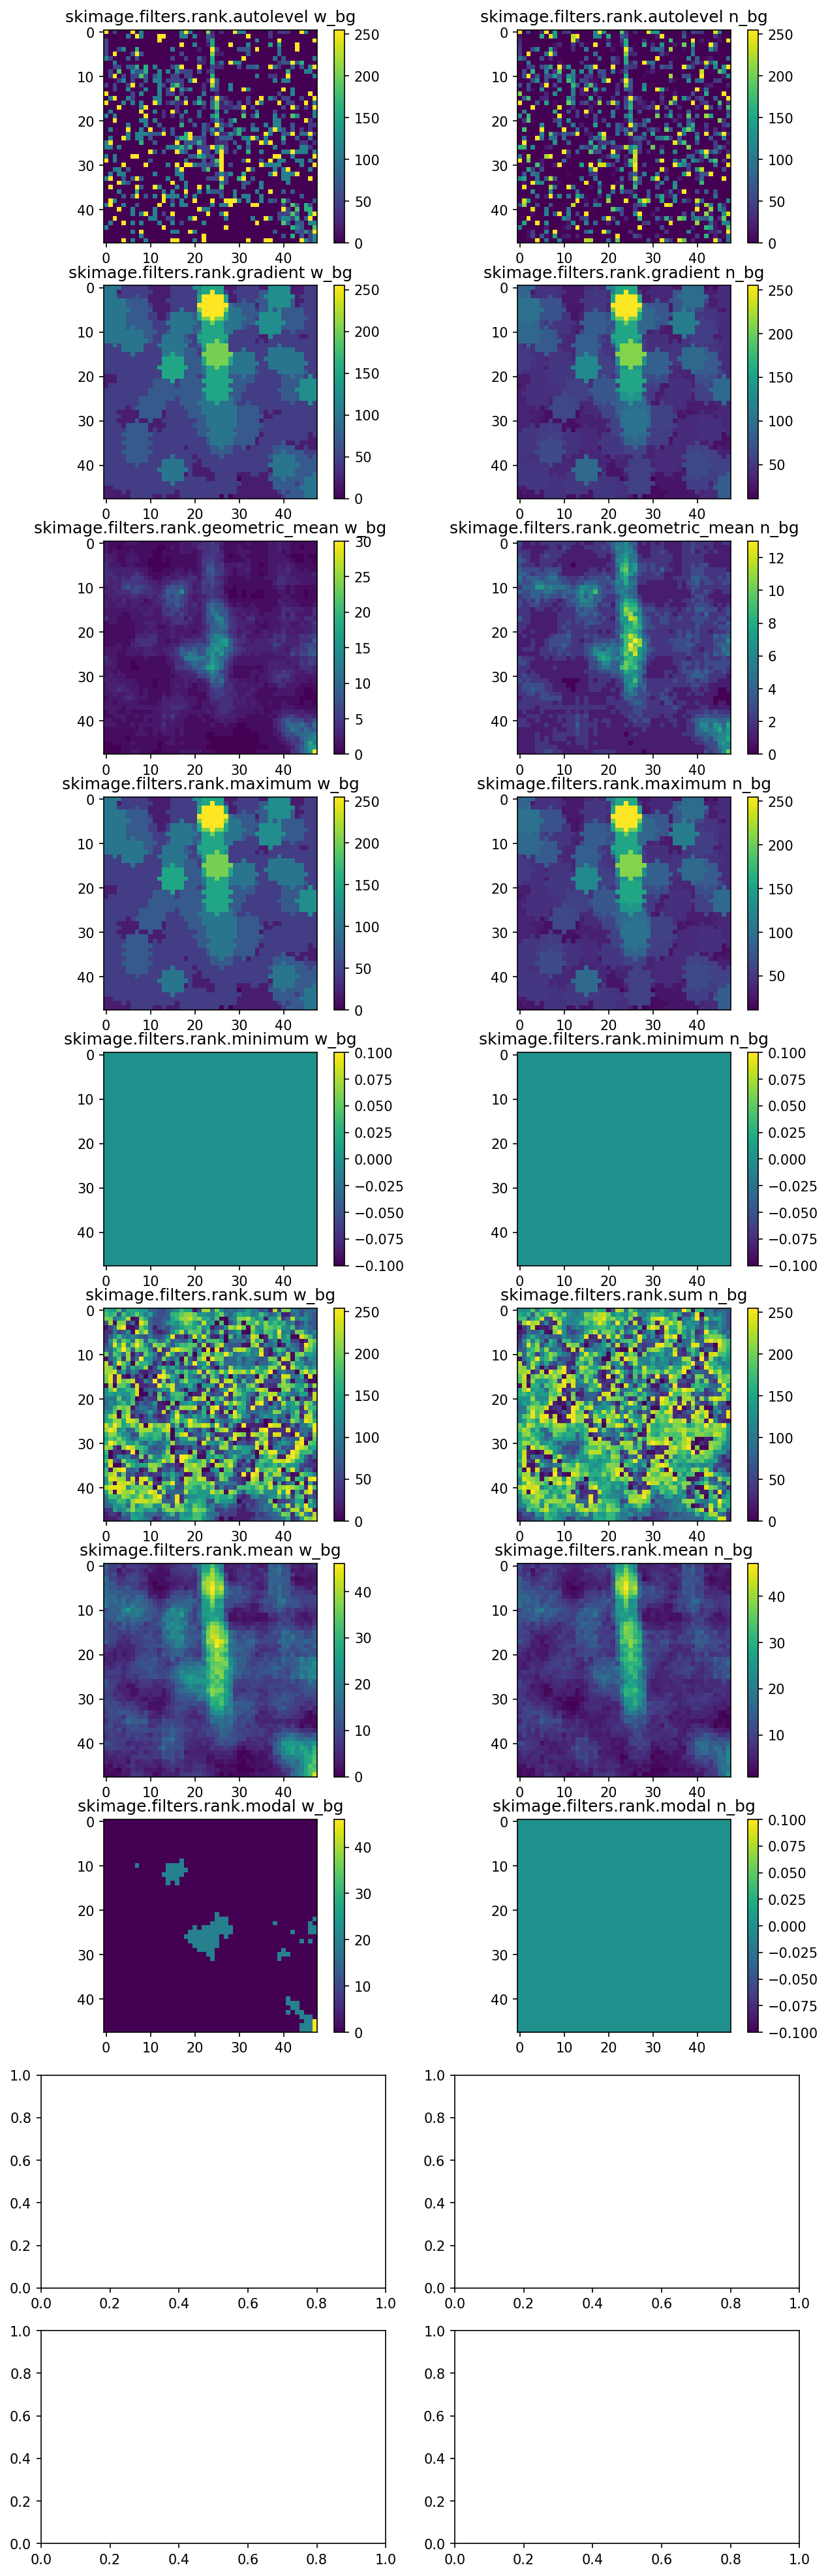

In [67]:
plt.close('all')
cols=2
rows=10
mpl.rcParams['figure.dpi'] = 80
fig, axs = plt.subplots(rows,cols)
fig.set_size_inches(cols*5,rows*4*0.85)
axs_flattened = axs.flatten()
i=0
cax = axs_flattened[i].imshow( skimage.filters.rank.autolevel(base_xy_proj_w_bg_max_norm, skimage.morphology.disk(3)) ) 
axs_flattened[i].set_title('skimage.filters.rank.autolevel w_bg')
fig.colorbar(cax, ax=axs_flattened[i])
i += 1
cax = axs_flattened[i].imshow( skimage.filters.rank.autolevel(base_xy_proj_n_bg_max_norm, skimage.morphology.disk(3)) )
axs_flattened[i].set_title('skimage.filters.rank.autolevel n_bg')
fig.colorbar(cax, ax=axs_flattened[i])
i += 1
cax = axs_flattened[i].imshow( skimage.filters.rank.gradient(base_xy_proj_w_bg_max_norm, skimage.morphology.disk(3)) ) 
axs_flattened[i].set_title('skimage.filters.rank.gradient w_bg')
fig.colorbar(cax, ax=axs_flattened[i])
i += 1
cax = axs_flattened[i].imshow( skimage.filters.rank.gradient(base_xy_proj_n_bg_max_norm, skimage.morphology.disk(3)) )
axs_flattened[i].set_title('skimage.filters.rank.gradient n_bg')
fig.colorbar(cax, ax=axs_flattened[i])
i += 1
cax = axs_flattened[i].imshow( skimage.filters.rank.geometric_mean(base_xy_proj_w_bg_max_norm, skimage.morphology.disk(3)) ) 
axs_flattened[i].set_title('skimage.filters.rank.geometric_mean w_bg')
fig.colorbar(cax, ax=axs_flattened[i])
i += 1
cax = axs_flattened[i].imshow( skimage.filters.rank.geometric_mean(base_xy_proj_n_bg_max_norm, skimage.morphology.disk(3)) )
axs_flattened[i].set_title('skimage.filters.rank.geometric_mean n_bg')
fig.colorbar(cax, ax=axs_flattened[i])
i += 1
cax = axs_flattened[i].imshow( skimage.filters.rank.maximum(base_xy_proj_w_bg_max_norm, skimage.morphology.disk(3)) ) 
axs_flattened[i].set_title('skimage.filters.rank.maximum w_bg')
fig.colorbar(cax, ax=axs_flattened[i])
i += 1
cax = axs_flattened[i].imshow( skimage.filters.rank.maximum(base_xy_proj_n_bg_max_norm, skimage.morphology.disk(3)) )
axs_flattened[i].set_title('skimage.filters.rank.maximum n_bg')
fig.colorbar(cax, ax=axs_flattened[i])
i += 1
cax = axs_flattened[i].imshow( skimage.filters.rank.minimum(base_xy_proj_w_bg_max_norm, skimage.morphology.disk(3)) ) 
axs_flattened[i].set_title('skimage.filters.rank.minimum w_bg')
fig.colorbar(cax, ax=axs_flattened[i])
i += 1
cax = axs_flattened[i].imshow( skimage.filters.rank.minimum(base_xy_proj_n_bg_max_norm, skimage.morphology.disk(3)) )
axs_flattened[i].set_title('skimage.filters.rank.minimum n_bg')
fig.colorbar(cax, ax=axs_flattened[i])
i += 1
cax = axs_flattened[i].imshow( skimage.filters.rank.sum(base_xy_proj_w_bg_max_norm, skimage.morphology.disk(3)) ) 
axs_flattened[i].set_title('skimage.filters.rank.sum w_bg')
fig.colorbar(cax, ax=axs_flattened[i])
i += 1
cax = axs_flattened[i].imshow( skimage.filters.rank.sum(base_xy_proj_n_bg_max_norm, skimage.morphology.disk(3)) )
axs_flattened[i].set_title('skimage.filters.rank.sum n_bg')
fig.colorbar(cax, ax=axs_flattened[i])
i += 1
cax = axs_flattened[i].imshow( skimage.filters.rank.mean(base_xy_proj_w_bg_max_norm, skimage.morphology.disk(3)) ) 
axs_flattened[i].set_title('skimage.filters.rank.mean w_bg')
fig.colorbar(cax, ax=axs_flattened[i])
i += 1
cax = axs_flattened[i].imshow( skimage.filters.rank.mean(base_xy_proj_n_bg_max_norm, skimage.morphology.disk(3)) )
axs_flattened[i].set_title('skimage.filters.rank.mean n_bg')
fig.colorbar(cax, ax=axs_flattened[i])
i += 1
cax = axs_flattened[i].imshow( skimage.filters.rank.modal(base_xy_proj_w_bg_max_norm, skimage.morphology.disk(3)) ) 
axs_flattened[i].set_title('skimage.filters.rank.modal w_bg')
fig.colorbar(cax, ax=axs_flattened[i])
i += 1
cax = axs_flattened[i].imshow( skimage.filters.rank.modal(base_xy_proj_n_bg_max_norm, skimage.morphology.disk(3)) )
axs_flattened[i].set_title('skimage.filters.rank.modal n_bg')
fig.colorbar(cax, ax=axs_flattened[i])
i += 1

plt.show()

/home/eusobg/EUSO-SPB/euso-spb-patt-reco-v1/venv/lib/python3.5/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float32 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/home/eusobg/EUSO-SPB/euso-spb-patt-reco-v1/venv/lib/python3.5/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


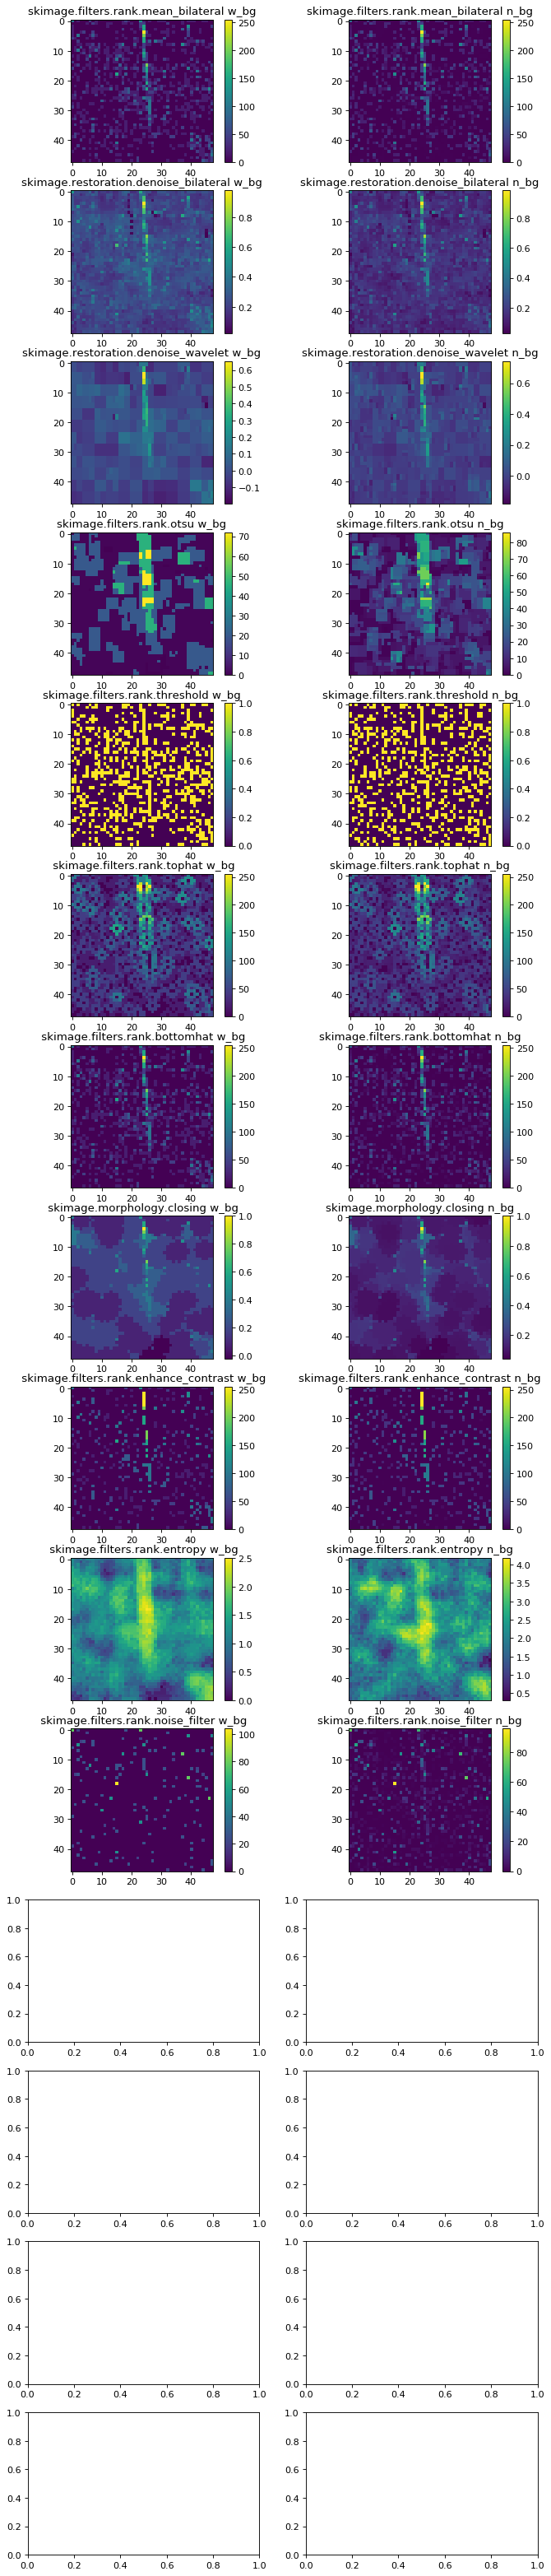

In [73]:
plt.close('all')
cols=2
rows=15
mpl.rcParams['figure.dpi'] = 80
fig, axs = plt.subplots(rows,cols)
fig.set_size_inches(cols*5,rows*4*0.85)
axs_flattened = axs.flatten()
i=0

cax = axs_flattened[i].imshow( skimage.filters.rank.mean_bilateral(base_xy_proj_w_bg_max_norm, skimage.morphology.disk(3)) ) 
axs_flattened[i].set_title('skimage.filters.rank.mean_bilateral w_bg')
fig.colorbar(cax, ax=axs_flattened[i])
i += 1
cax = axs_flattened[i].imshow( skimage.filters.rank.mean_bilateral(base_xy_proj_n_bg_max_norm, skimage.morphology.disk(3)) )
axs_flattened[i].set_title('skimage.filters.rank.mean_bilateral n_bg')
fig.colorbar(cax, ax=axs_flattened[i])
i += 1

base_xy_proj_w_bg_max_norm_positive = base_xy_proj_w_bg_max_norm-np.min(base_xy_proj_w_bg_max_norm)
base_xy_proj_w_bg_max_norm_positive /= np.max(base_xy_proj_w_bg_max_norm_positive)

base_xy_proj_n_bg_max_norm_positive = base_xy_proj_n_bg_max_norm-np.min(base_xy_proj_n_bg_max_norm)
base_xy_proj_n_bg_max_norm_positive /= np.max(base_xy_proj_n_bg_max_norm_positive)

cax = axs_flattened[i].imshow( skimage.restoration.denoise_bilateral(base_xy_proj_w_bg_max_norm_positive, multichannel=False) ) 
axs_flattened[i].set_title('skimage.restoration.denoise_bilateral w_bg')
fig.colorbar(cax, ax=axs_flattened[i])
i += 1
cax = axs_flattened[i].imshow( skimage.restoration.denoise_bilateral(base_xy_proj_n_bg_max_norm_positive, multichannel=False) )
axs_flattened[i].set_title('skimage.restoration.denoise_bilateral n_bg')
fig.colorbar(cax, ax=axs_flattened[i])
i += 1
cax = axs_flattened[i].imshow( skimage.restoration.denoise_wavelet(base_xy_proj_w_bg_max_norm, multichannel=False) ) 
axs_flattened[i].set_title('skimage.restoration.denoise_wavelet w_bg')
fig.colorbar(cax, ax=axs_flattened[i])
i += 1
cax = axs_flattened[i].imshow( skimage.restoration.denoise_wavelet(base_xy_proj_n_bg_max_norm, multichannel=False) )
axs_flattened[i].set_title('skimage.restoration.denoise_wavelet n_bg')
fig.colorbar(cax, ax=axs_flattened[i])
i += 1


cax = axs_flattened[i].imshow( skimage.filters.rank.otsu(base_xy_proj_w_bg_max_norm, skimage.morphology.square(4)) ) 
axs_flattened[i].set_title('skimage.filters.rank.otsu w_bg')
fig.colorbar(cax, ax=axs_flattened[i])
i += 1
cax = axs_flattened[i].imshow( skimage.filters.rank.otsu(base_xy_proj_n_bg_max_norm, skimage.morphology.square(4)) )
axs_flattened[i].set_title('skimage.filters.rank.otsu n_bg')
fig.colorbar(cax, ax=axs_flattened[i])
i += 1
cax = axs_flattened[i].imshow( skimage.filters.rank.threshold(base_xy_proj_w_bg_max_norm, skimage.morphology.disk(2)) ) 
axs_flattened[i].set_title('skimage.filters.rank.threshold w_bg')
fig.colorbar(cax, ax=axs_flattened[i])
i += 1
cax = axs_flattened[i].imshow( skimage.filters.rank.threshold(base_xy_proj_n_bg_max_norm, skimage.morphology.disk(2)) )
axs_flattened[i].set_title('skimage.filters.rank.threshold n_bg')
fig.colorbar(cax, ax=axs_flattened[i])
i += 1
cax = axs_flattened[i].imshow( skimage.filters.rank.tophat(base_xy_proj_w_bg_max_norm, skimage.morphology.disk(2)) ) 
axs_flattened[i].set_title(' skimage.filters.rank.tophat w_bg')
fig.colorbar(cax, ax=axs_flattened[i])
i += 1
cax = axs_flattened[i].imshow( skimage.filters.rank.tophat(base_xy_proj_n_bg_max_norm, skimage.morphology.disk(2)) )
axs_flattened[i].set_title('skimage.filters.rank.tophat n_bg')
fig.colorbar(cax, ax=axs_flattened[i])
i += 1
cax = axs_flattened[i].imshow( skimage.filters.rank.bottomhat(base_xy_proj_w_bg_max_norm, skimage.morphology.disk(2)) ) 
axs_flattened[i].set_title(' skimage.filters.rank.bottomhat w_bg')
fig.colorbar(cax, ax=axs_flattened[i])
i += 1
cax = axs_flattened[i].imshow( skimage.filters.rank.bottomhat(base_xy_proj_n_bg_max_norm, skimage.morphology.disk(2)) )
axs_flattened[i].set_title('skimage.filters.rank.bottomhat n_bg')
fig.colorbar(cax, ax=axs_flattened[i])
i += 1
cax = axs_flattened[i].imshow( skimage.morphology.closing(base_xy_proj_w_bg_max_norm, skimage.morphology.disk(3) ) )  #
axs_flattened[i].set_title(' skimage.morphology.closing w_bg')
fig.colorbar(cax, ax=axs_flattened[i])
i += 1
cax = axs_flattened[i].imshow( skimage.morphology.closing(base_xy_proj_n_bg_max_norm, skimage.morphology.disk(3)) ) #
axs_flattened[i].set_title('skimage.morphology.closing n_bg')
fig.colorbar(cax, ax=axs_flattened[i])
i += 1
cax = axs_flattened[i].imshow( skimage.filters.rank.enhance_contrast(base_xy_proj_w_bg_max_norm, skimage.morphology.disk(2)) ) 
axs_flattened[i].set_title(' skimage.filters.rank.enhance_contrast w_bg')
fig.colorbar(cax, ax=axs_flattened[i])
i += 1
cax = axs_flattened[i].imshow( skimage.filters.rank.enhance_contrast(base_xy_proj_n_bg_max_norm, skimage.morphology.disk(2)) )
axs_flattened[i].set_title('skimage.filters.rank.enhance_contrast n_bg')
fig.colorbar(cax, ax=axs_flattened[i])
i += 1
cax = axs_flattened[i].imshow( skimage.filters.rank.entropy(base_xy_proj_w_bg_max_norm, skimage.morphology.disk(3)) ) 
axs_flattened[i].set_title(' skimage.filters.rank.entropy w_bg')
fig.colorbar(cax, ax=axs_flattened[i])
i += 1
cax = axs_flattened[i].imshow( skimage.filters.rank.entropy(base_xy_proj_n_bg_max_norm, skimage.morphology.disk(3)) )
axs_flattened[i].set_title('skimage.filters.rank.entropy n_bg')
fig.colorbar(cax, ax=axs_flattened[i])
i += 1
cax = axs_flattened[i].imshow( skimage.filters.rank.noise_filter(base_xy_proj_w_bg_max_norm, skimage.morphology.disk(2)) ) 
axs_flattened[i].set_title(' skimage.filters.rank.noise_filter w_bg')
fig.colorbar(cax, ax=axs_flattened[i])
i += 1
cax = axs_flattened[i].imshow( skimage.filters.rank.noise_filter(base_xy_proj_n_bg_max_norm, skimage.morphology.disk(2)) )
axs_flattened[i].set_title('skimage.filters.rank.noise_filter n_bg')
fig.colorbar(cax, ax=axs_flattened[i])
i += 1

plt.show()

In [ ]:
plt.close('all')
cols=2
rows=1
fig, axs = plt.subplots(rows,cols)
fig.set_size_inches(cols*5,rows*4*0.85)
axs_flattened = axs.flatten()
i=0

cax = axs_flattened[i].imshow( skimage.filters.frangi(base_xy_proj_w_bg_max_norm) ) 
axs_flattened[i].set_title(' skimage.filters.frangi w_bg')
fig.colorbar(cax, ax=axs_flattened[i])
i += 1
cax = axs_flattened[i].imshow( skimage.filters.frangi(base_xy_proj_n_bg_max_norm) )
axs_flattened[i].set_title('skimage.filters.frangi n_bg')
fig.colorbar(cax, ax=axs_flattened[i])
i += 1

plt.show()

In [ ]:
plt.close('all')
cols=2
rows=12
fig, axs = plt.subplots(rows,cols)
fig.set_size_inches(cols*5,rows*4*0.85)
axs_flattened = axs.flatten()
i=0

# import skimage.data    
freq = 0.1
band = 1
sigma_x = None
sigma_y = None

cax = axs_flattened[i].imshow( skimage.filters.gabor_kernel(freq, band, np.deg2rad(20), sigma_x, sigma_y).real )  #base_xy_proj_w_bg
axs_flattened[i].set_title(' skimage.filters.gabor_kernel.real') #  w_bg
fig.colorbar(cax, ax=axs_flattened[i])
i += 1
cax = axs_flattened[i].imshow( skimage.filters.gabor_kernel(freq, band, np.deg2rad(20), sigma_x, sigma_y).imag )  #base_xy_proj_w_bg
axs_flattened[i].set_title(' skimage.filters.gabor_kernel.imag') #  w_bg
fig.colorbar(cax, ax=axs_flattened[i])
i += 1

gabor_input = base_xy_proj_n_bg_max_norm
base_xy_proj_w_bg_max_norm_gabor = skimage.filters.gabor(gabor_input, freq, np.deg2rad(0), band, sigma_x, sigma_y) #base_xy_proj_w_bg_max_norm
cax = axs_flattened[i].imshow( base_xy_proj_w_bg_max_norm_gabor[0] )  #base_xy_proj_w_bg
axs_flattened[i].set_title(' skimage.filters.gabor [0]') #  w_bg
fig.colorbar(cax, ax=axs_flattened[i])
i += 1                  
cax = axs_flattened[i].imshow( base_xy_proj_w_bg_max_norm_gabor[1] )  #base_xy_proj_w_bg
axs_flattened[i].set_title(' skimage.filters.gabor [1]') #  w_bg
fig.colorbar(cax, ax=axs_flattened[i])
i += 1               
base_xy_proj_w_bg_max_norm_gabor = skimage.filters.gabor(gabor_input, freq, np.deg2rad(10), band, sigma_x, sigma_y) #base_xy_proj_w_bg_max_norm
cax = axs_flattened[i].imshow( base_xy_proj_w_bg_max_norm_gabor[0] )  #base_xy_proj_w_bg
axs_flattened[i].set_title(' skimage.filters.gabor [0]') #  w_bg
fig.colorbar(cax, ax=axs_flattened[i])
i += 1                  
cax = axs_flattened[i].imshow( base_xy_proj_w_bg_max_norm_gabor[1] )  #base_xy_proj_w_bg
axs_flattened[i].set_title(' skimage.filters.gabor [1]') #  w_bg
fig.colorbar(cax, ax=axs_flattened[i])
i += 1                  

base_xy_proj_w_bg_max_norm_gabor = skimage.filters.gabor(gabor_input, freq, np.deg2rad(20), band, sigma_x, sigma_y) #base_xy_proj_w_bg_max_norm
cax = axs_flattened[i].imshow( base_xy_proj_w_bg_max_norm_gabor[0] )  #base_xy_proj_w_bg
axs_flattened[i].set_title(' skimage.filters.gabor [0]') #  w_bg
fig.colorbar(cax, ax=axs_flattened[i])
i += 1                  
cax = axs_flattened[i].imshow( base_xy_proj_w_bg_max_norm_gabor[1] )  #base_xy_proj_w_bg
axs_flattened[i].set_title(' skimage.filters.gabor [1]') #  w_bg
fig.colorbar(cax, ax=axs_flattened[i])
i += 1             
base_xy_proj_w_bg_max_norm_gabor = skimage.filters.gabor(gabor_input, freq, np.deg2rad(30), band, sigma_x, sigma_y) #base_xy_proj_w_bg_max_norm
cax = axs_flattened[i].imshow( base_xy_proj_w_bg_max_norm_gabor[0] )  #base_xy_proj_w_bg
axs_flattened[i].set_title(' skimage.filters.gabor [0]') #  w_bg
fig.colorbar(cax, ax=axs_flattened[i])
i += 1                  
cax = axs_flattened[i].imshow( base_xy_proj_w_bg_max_norm_gabor[1] )  #base_xy_proj_w_bg
axs_flattened[i].set_title(' skimage.filters.gabor [1]') #  w_bg
fig.colorbar(cax, ax=axs_flattened[i])
i += 1             
base_xy_proj_w_bg_max_norm_gabor = skimage.filters.gabor(gabor_input, freq, np.deg2rad(40), band, sigma_x, sigma_y) #base_xy_proj_w_bg_max_norm
cax = axs_flattened[i].imshow( base_xy_proj_w_bg_max_norm_gabor[0] )  #base_xy_proj_w_bg
axs_flattened[i].set_title(' skimage.filters.gabor [0]') #  w_bg
fig.colorbar(cax, ax=axs_flattened[i])
i += 1                  
cax = axs_flattened[i].imshow( base_xy_proj_w_bg_max_norm_gabor[1] )  #base_xy_proj_w_bg
axs_flattened[i].set_title(' skimage.filters.gabor [1]') #  w_bg
fig.colorbar(cax, ax=axs_flattened[i])
i += 1             
base_xy_proj_w_bg_max_norm_gabor = skimage.filters.gabor(gabor_input, freq, np.deg2rad(50), band, sigma_x, sigma_y) #base_xy_proj_w_bg_max_norm
cax = axs_flattened[i].imshow( base_xy_proj_w_bg_max_norm_gabor[0] )  #base_xy_proj_w_bg
axs_flattened[i].set_title(' skimage.filters.gabor [0]') #  w_bg
fig.colorbar(cax, ax=axs_flattened[i])
i += 1                  
cax = axs_flattened[i].imshow( base_xy_proj_w_bg_max_norm_gabor[1] )  #base_xy_proj_w_bg
axs_flattened[i].set_title(' skimage.filters.gabor [1]') #  w_bg
fig.colorbar(cax, ax=axs_flattened[i])
i += 1             
base_xy_proj_w_bg_max_norm_gabor = skimage.filters.gabor(gabor_input, freq, np.deg2rad(60), band, sigma_x, sigma_y) #base_xy_proj_w_bg_max_norm
cax = axs_flattened[i].imshow( base_xy_proj_w_bg_max_norm_gabor[0] )  #base_xy_proj_w_bg
axs_flattened[i].set_title(' skimage.filters.gabor [0]') #  w_bg
fig.colorbar(cax, ax=axs_flattened[i])
i += 1                  
cax = axs_flattened[i].imshow( base_xy_proj_w_bg_max_norm_gabor[1] )  #base_xy_proj_w_bg
axs_flattened[i].set_title(' skimage.filters.gabor [1]') #  w_bg
fig.colorbar(cax, ax=axs_flattened[i])
i += 1        
base_xy_proj_w_bg_max_norm_gabor = skimage.filters.gabor(gabor_input, freq, np.deg2rad(70), band, sigma_x, sigma_y) #base_xy_proj_w_bg_max_norm
cax = axs_flattened[i].imshow( base_xy_proj_w_bg_max_norm_gabor[0] )  #base_xy_proj_w_bg
axs_flattened[i].set_title(' skimage.filters.gabor [0]') #  w_bg
fig.colorbar(cax, ax=axs_flattened[i])
i += 1                  
cax = axs_flattened[i].imshow( base_xy_proj_w_bg_max_norm_gabor[1] )  #base_xy_proj_w_bg
axs_flattened[i].set_title(' skimage.filters.gabor [1]') #  w_bg
fig.colorbar(cax, ax=axs_flattened[i])
i += 1    
base_xy_proj_w_bg_max_norm_gabor = skimage.filters.gabor(gabor_input, freq, np.deg2rad(80), band, sigma_x, sigma_y) #base_xy_proj_w_bg_max_norm
cax = axs_flattened[i].imshow( base_xy_proj_w_bg_max_norm_gabor[0] )  #base_xy_proj_w_bg
axs_flattened[i].set_title(' skimage.filters.gabor [0]') #  w_bg
fig.colorbar(cax, ax=axs_flattened[i])
i += 1                  
cax = axs_flattened[i].imshow( base_xy_proj_w_bg_max_norm_gabor[1] )  #base_xy_proj_w_bg
axs_flattened[i].set_title(' skimage.filters.gabor [1]') #  w_bg
fig.colorbar(cax, ax=axs_flattened[i])
i += 1                     
base_xy_proj_w_bg_max_norm_gabor = skimage.filters.gabor(gabor_input, freq, np.deg2rad(90), band, sigma_x, sigma_y) #base_xy_proj_w_bg_max_norm
cax = axs_flattened[i].imshow( base_xy_proj_w_bg_max_norm_gabor[0] )  #base_xy_proj_w_bg
axs_flattened[i].set_title(' skimage.filters.gabor [0]') #  w_bg
fig.colorbar(cax, ax=axs_flattened[i])
i += 1                  
cax = axs_flattened[i].imshow( base_xy_proj_w_bg_max_norm_gabor[1] )  #base_xy_proj_w_bg
axs_flattened[i].set_title(' skimage.filters.gabor [1]') #  w_bg
fig.colorbar(cax, ax=axs_flattened[i])
i += 1                        
base_xy_proj_w_bg_max_norm_gabor = skimage.filters.gabor(gabor_input, freq, np.deg2rad(100), band, sigma_x, sigma_y) #base_xy_proj_w_bg_max_norm
cax = axs_flattened[i].imshow( base_xy_proj_w_bg_max_norm_gabor[0] )  #base_xy_proj_w_bg
axs_flattened[i].set_title(' skimage.filters.gabor [0]') #  w_bg
fig.colorbar(cax, ax=axs_flattened[i])
i += 1                  
cax = axs_flattened[i].imshow( base_xy_proj_w_bg_max_norm_gabor[1] )  #base_xy_proj_w_bg
axs_flattened[i].set_title(' skimage.filters.gabor [1]') #  w_bg
fig.colorbar(cax, ax=axs_flattened[i])
i += 1   
# cax = axs_flattened[i].imshow( skimage.filters.gabor(base_xy_proj_n_bg_max_norm, 0.6) )
# axs_flattened[i].set_title('skimage.filters.gabor n_bg')
# fig.colorbar(cax, ax=axs_flattened[i])
# i += 1

# base_xy_proj_w_bg_max_norm_positive = base_xy_proj_w_bg_max_norm-np.min(base_xy_proj_w_bg_max_norm)
# base_xy_proj_w_bg_max_norm_positive /= np.max(base_xy_proj_w_bg_max_norm_positive)

# base_xy_proj_n_bg_max_norm_positive = base_xy_proj_n_bg_max_norm-np.min(base_xy_proj_n_bg_max_norm)
# base_xy_proj_n_bg_max_norm_positive /= np.max(base_xy_proj_n_bg_max_norm_positive)

# cax = axs_flattened[i].imshow( skimage.restoration.denoise_bilateral(base_xy_proj_w_bg_max_norm_positive, multichannel=False) ) 
# axs_flattened[i].set_title('skimage.restoration.denoise_bilateral w_bg')
# fig.colorbar(cax, ax=axs_flattened[i])
# i += 1
# cax = axs_flattened[i].imshow( skimage.restoration.denoise_bilateral(base_xy_proj_n_bg_max_norm_positive, multichannel=False) )
# axs_flattened[i].set_title('skimage.restoration.denoise_bilateral n_bg')
# fig.colorbar(cax, ax=axs_flattened[i])
# i += 1
# cax = axs_flattened[i].imshow( skimage.restoration.denoise_wavelet(base_xy_proj_w_bg_max_norm, multichannel=False) ) 
# axs_flattened[i].set_title('skimage.restoration.denoise_wavelet w_bg')
# fig.colorbar(cax, ax=axs_flattened[i])
# i += 1
# cax = axs_flattened[i].imshow( skimage.restoration.denoise_wavelet(base_xy_proj_n_bg_max_norm, multichannel=False) )
# axs_flattened[i].set_title('skimage.restoration.denoise_wavelet n_bg')
# fig.colorbar(cax, ax=axs_flattened[i])
# i += 1

plt.show()

In [ ]:
def compute_feats(image, kernels):
    feats = np.zeros((len(kernels), 2), dtype=np.double)
    for k, kernel in enumerate(kernels):
        filtered = scipy.ndimage.convolve(image, kernel, mode='wrap')
        feats[k, 0] = filtered.mean()
        feats[k, 1] = filtered.var()
    return feats

def match(feats, ref_feats):
    min_error = np.inf
    min_i = None
    for i in range(ref_feats.shape[0]):
        error = np.sum((feats - ref_feats[i, :])**2)
        if error < min_error:
            min_error = error
            min_i = i
    return min_i


def vis_match(feats, ref_feats):
    cols = 4
    rows = int(np.ceil(len(feats)/cols))
#     fig, axs = plt.subplots(rows, cols)
#     axs_flattened = axs.flatten()
#     fig.set_size_inches(cols*5.5,rows*4*0.85)
    min_error = np.inf
    min_i = None
    for i in range(ref_feats.shape[0]):
        error = np.sum((feats - ref_feats[i, :])**2)
        title = "e: {:.5f}".format(error)
        if error < min_error:
            min_error = error
            min_i = i
            title += " | m"
        
        print(i, title)
#         axs_flattened[k].imshow( (feats - ref_feats[i, :])**2 )
#         axs_flattened[k].set_title(title)
        
    return min_i

def vis_feats(image, kernels, kernel_labels=[]):
    cols = 4
    rows = int(np.ceil(len(kernels)/cols))
    fig, axs = plt.subplots(rows, cols)
    fig.set_size_inches(cols*5.5,rows*4*0.85)
    axs_flattened = axs.flatten()
    feats = np.zeros((len(kernels), 2), dtype=np.double)
    for k, kernel in enumerate(kernels):
        filtered = scipy.ndimage.convolve(image, kernel, mode='wrap')
#         feats[k, 0] = filtered.mean()
#         feats[k, 1] = filtered.var()
        axs_flattened[k].imshow(filtered)
        title = "m: {:.5f} v: {:.5f}".format(filtered.mean(), filtered.var())
        if k < len(kernel_labels):
            title += " | t: {:.3f} s: {:.3f} f: {:.3f}".format(*kernel_labels[k])
        axs_flattened[k].set_title(title)
    return fig, axs

def calc_gabor_kernels(ntheta=4, sigmas=(1,3), frequencies=(0.05, 0.25)):
    kernels = []
    for theta in range(4):
        theta = theta / 4. * np.pi
        for sigma in sigmas:
            for frequency in frequencies:
                kernel = np.real(skimage.filters.gabor_kernel(frequency, theta=theta,
                                              sigma_x=sigma, sigma_y=sigma))
                kernels.append(kernel)
    return kernels

def get_gabor_kernel_labels(ntheta=4, sigmas=(1,3), frequencies=(0.05, 0.25)):
    kernels = []
    for theta in range(4):
        theta = theta / 4. * np.pi
        for sigma in sigmas:
            for frequency in frequencies:
                kernel = (frequency, theta, sigma)
                kernels.append(kernel)
    return kernels

def vis_gabor_kernels(kernels, labels=[]):
    cols = 4
    rows = int(np.ceil(len(kernels)/cols))
    fig, axs = plt.subplots(rows, cols)
    fig.set_size_inches(cols*5,rows*4*0.85)
    axs_flattened = axs.flatten()
    feats = np.zeros((len(kernels), 2), dtype=np.double)
    for k, kernel in enumerate(kernels):
        axs_flattened[k].imshow(kernel)
        if k < len(labels):
            axs_flattened[k].set_title("t: {:.3f} s: {:.3f} f: {:.3f}".format(*labels[k]))
    return fig, axs

In [ ]:
# gabor_kernels = calc_gabor_kernels(6,(1,2,3),(0.05, 0.25, 0.55))
# gabor_kernel_labels = get_gabor_kernel_labels(6,(1,2,3),(0.05, 0.25, 0.55))
gabor_kernels = calc_gabor_kernels(6,(1,2,3),(0.05, 0.25, 0.55))
gabor_kernel_labels = get_gabor_kernel_labels(6,(1,2,3),(0.05, 0.25, 0.55))

In [ ]:
plt.close('all')
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['figure.dpi'] = 150

# fig, ax = plt.subplots(1)
# cax = ax.imshow(  scipy.signal.order_filter(base_xy_proj_w_bg, order_filter_morphhology, 18), cmap='binary', vmin=0, vmax=6)
# fig.colorbar(cax, label="counts", ax=ax)

print(gabor_kernel_labels[16])

fig, ax = plt.subplots(1)
cax = ax.imshow(  gabor_kernels[16] , cmap='binary',) #
fig.colorbar(cax, label="gabor wavelet value", ax=ax)  

base_xy_proj_max_norm_gabor = scipy.ndimage.convolve(base_xy_proj_max_norm, gabor_kernels[16], mode='wrap')

print(base_xy_proj_max_norm_gabor.mean(), base_xy_proj_max_norm_gabor.var())

fig, ax = plt.subplots(1)
cax = ax.imshow(  base_xy_proj_max_norm_gabor  , cmap='binary',) #
fig.colorbar(cax, label="normalized counts", ax=ax)  

plt.show()

In [ ]:
vis_gabor_kernels(gabor_kernels, gabor_kernel_labels)
plt.show()

In [ ]:
vis_feats(base_xy_proj_max_norm, gabor_kernels, gabor_kernel_labels) # base_xy_proj_n_bg_max_norm
plt.show()

In [ ]:
vis_feats( scipy.ndimage.rotate(base_xy_proj_max_norm, angle=190, reshape=False), gabor_kernels, gabor_kernel_labels) # base_xy_proj_n_bg_max_norm
plt.show()

In [ ]:
vis_feats(bg_xy_proj_cent_max_norm, gabor_kernels, gabor_kernel_labels) # base_xy_proj_n_bg_max_norm
plt.show()

In [ ]:
ref_feats = np.zeros((2, len(gabor_kernels), 2), dtype=np.double)
ref_feats[1, :, :] = compute_feats(base_xy_proj_max_norm, gabor_kernels)
ref_feats[0, :, :] = compute_feats(bg_xy_proj_cent_max_norm, gabor_kernels)

In [ ]:
n2 = 42
base_xy_proj_2 = xy_projections_bgsub[n2] * (xy_projections_bgsub[n2]>0)

print("mean",  base_xy_proj_2.mean())

base_xy_proj_2_cent = (base_xy_proj_2 - base_xy_proj_2.mean() )

print('max(abs(cent))', np.max(np.abs(base_xy_proj_2_cent)))

base_xy_proj_2_max_norm = base_xy_proj_2_cent/np.max(np.abs(base_xy_proj_2_cent))
base_xy_proj_2_std_norm = base_xy_proj_2_cent/np.std(base_xy_proj_2_cent)

In [ ]:
cax = plt.imshow(base_xy_proj_2_max_norm) # bg_xy_proj_cent_max_norm
plt.colorbar(cax)
plt.show()

In [ ]:

feats = compute_feats( scipy.ndimage.rotate(base_xy_proj_max_norm, angle=19, reshape=False), gabor_kernels) # base_xy_proj_n_bg_max_norm
print(match(feats, ref_feats))
vis_match(feats, ref_feats)
print("----------------------")
feats = compute_feats( scipy.ndimage.rotate(base_xy_proj_max_norm, angle=190, reshape=False), gabor_kernels) # base_xy_proj_n_bg_max_norm
print(match(feats, ref_feats))
vis_match(feats, ref_feats)
print("----------------------")
feats = compute_feats( scipy.ndimage.rotate(base_xy_proj_max_norm, angle=100, reshape=False), gabor_kernels) # base_xy_proj_n_bg_max_norm
print(match(feats, ref_feats))
vis_match(feats, ref_feats)
print("----------------------")
feats = compute_feats( scipy.ndimage.rotate(base_xy_proj_max_norm, angle=60, reshape=False), gabor_kernels) # base_xy_proj_n_bg_max_norm
print(match(feats, ref_feats))
vis_match(feats, ref_feats)
print("----------------------")
print("----------------------")
feats = compute_feats( bg_xy_proj_cent_max_norm, gabor_kernels) # base_xy_proj_n_bg_max_norm
print(match(feats, ref_feats))
vis_match(feats, ref_feats)
print("----------------------")
feats = compute_feats( scipy.ndimage.rotate(bg_xy_proj_cent_max_norm, angle=19, reshape=False), gabor_kernels) # base_xy_proj_n_bg_max_norm
print(match(feats, ref_feats))
vis_match(feats, ref_feats)
print("----------------------")
feats = compute_feats( scipy.ndimage.rotate(bg_xy_proj_cent_max_norm, angle=190, reshape=False), gabor_kernels) # base_xy_proj_n_bg_max_norm
print(match(feats, ref_feats))
vis_match(feats, ref_feats)
print("----------------------")
feats = compute_feats( scipy.ndimage.rotate(bg_xy_proj_cent_max_norm, angle=100, reshape=False), gabor_kernels) # base_xy_proj_n_bg_max_norm
print(match(feats, ref_feats))
vis_match(feats, ref_feats)
print("----------------------")
feats = compute_feats( scipy.ndimage.rotate(bg_xy_proj_cent_max_norm, angle=60, reshape=False), gabor_kernels) # base_xy_proj_n_bg_max_norm
print(match(feats, ref_feats))
vis_match(feats, ref_feats)
# plt.show()
print("----------------------")
print("----------------------")
feats = compute_feats( base_xy_proj_2_max_norm, gabor_kernels) # base_xy_proj_n_bg_max_norm
vis_match(feats, ref_feats)

In [ ]:
visible_shower_classes = np.zeros(len(xy_projections_bgsub))
for k, xy_projection in enumerate(xy_projections_bgsub):
    if k == n: 
        continue
    c_xy_proj_w_bg = xy_projection * (xy_projection>0)
    c_xy_proj_w_bg_cent = (c_xy_proj_w_bg - c_xy_proj_w_bg.mean() )
    c_xy_proj_w_bg_max_norm = c_xy_proj_w_bg_cent/np.max(np.abs(c_xy_proj_w_bg_cent))
    feats = compute_feats(c_xy_proj_w_bg_max_norm, gabor_kernels)
    visible_shower_classes[k] = match(feats, ref_feats)
    if k % 500 == 0:
        print(k)

In [ ]:
print("num class 0:", len(visible_shower_classes) - np.count_nonzero(visible_shower_classes) )
print("num class 1:", np.count_nonzero(visible_shower_classes) )

In [ ]:
print("error: ",(len(visible_shower_classes) - np.count_nonzero(visible_shower_classes))/len(visible_shower_classes))
print("efficiency: ",np.count_nonzero(visible_shower_classes)/len(visible_shower_classes))

In [ ]:
background_classes = np.zeros(len(frames_background_xy_projections))
for n, xy_projection in enumerate(frames_background_xy_projections):
    if k == n: 
        continue
    c_xy_proj_w_bg = xy_projection * (xy_projection>0)
    c_xy_proj_w_bg_cent = (c_xy_proj_w_bg - c_xy_proj_w_bg.mean() )
    c_xy_proj_w_bg_max_norm = c_xy_proj_w_bg_cent/np.max(np.abs(c_xy_proj_w_bg_cent))
    feats = compute_feats(c_xy_proj_w_bg_max_norm, gabor_kernels)
    background_classes[k] = match(feats, ref_feats)
    if k % 500 == 0:
        print(k)
    
print("num class 0:", len(background_classes) - np.count_nonzero(background_classes) )
print("num class 1:", np.count_nonzero(background_classes) )

In [ ]:
print("error: ",(len(background_classes) - np.count_nonzero(background_classes))/len(background_classes))
print("efficiency: ",np.count_nonzero(background_classes)/len(background_classes))

In [ ]:
print("error: ",(len(background_classes) - np.count_nonzero(background_classes) + len(visible_shower_classes) - np.count_nonzero(visible_shower_classes))/(len(visible_shower_classes)+len(background_classes))) 
print("efficiency: ",(np.count_nonzero(background_classes) + np.count_nonzero(visible_shower_classes))/(len(visible_shower_classes)+len(background_classes)))
